<a href="https://colab.research.google.com/github/The-One-Who-Speaks-and-Depicts/black-box/blob/main/Black_box_language_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and installations

In [ ]:
!pip install transformers
!pip install biopython
!pip install Levenshtein
!pip install pyjarowinkler
!pip install phonetic-algorithmIPA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.0 MB/s eta 0:00:00


In [ ]:
import os

from tqdm import tqdm

import hashlib
import random

import numpy as np
import pandas as pd

import re

from transformers import AutoTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from itertools import cycle

from Bio import Phylo
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

import matplotlib
import matplotlib.pyplot as plt

import Levenshtein
from pyjarowinkler.distance import get_jaro_distance as jw
from phonetic_algorithmIPA import ipa_distances

In [ ]:
pd.options.mode.chained_assignment = None

# Data loading and preprocessing

We start with loading dataset of the following format:
        
| Concept     | Lect1 | ... | LectN |
| ----------- | ----------- |----------- | ----------- |
| Concept 1 title in English | Concept 1 title in Lect 1 | ... | Concept 1 title in lect N |
| ... | ... | ... | ... |
| Concept M title in English | Concept M title in Lect 1 | ... | Concept M title in lect N |

In [ ]:
# We store current dataset name in variable DATA
DATA = 'Taa lects'
start_df = pd.read_csv('/content/Swadesh lists - Taa for cross-verification.csv', sep=',')
# drop concepts, for which we cannot compare lects
start_df = start_df.dropna()

In [ ]:
start_df.head()

,Concept,!Xoong,Kakia (Masarwa),Nǀuǁen
0,eye,!ʼĩ,ǁxʼwĩ,ǂʼũ
1,ear,ãʰ,waː,u-ša
2,nose,ùʰ-ɲa,u-ča,u-ša
3,tongue,ʔǀnàˤn,aːn,ǀʼaːni
4,tooth,ǁqʰː,ǁxũ,ǁʼʌn-te


In [ ]:
start_df.shape

(35, 4)

Then we acquire lect names.

In [ ]:
lect_rows = start_df.drop('Concept', axis=1)

In [ ]:
lects = list(lect_rows.columns)

In [ ]:
print(lects)

['!Xoong', 'Kakia (Masarwa)', 'Nǀuǁen ']


Then we transform the data in the format of dictionary, with the lect *i* name as a key, and list of pairs *concept j name in english - concept in lect i* as value for each *j* in concept list.

In [ ]:
wordlists = {}
for i in lects:
  wordlists[i] = list(zip(list(start_df['Concept']), list(start_df[i])))

In [ ]:
print(wordlists)

{'!Xoong': [('eye', '!ʼ\ue8d7ĩ'), ('ear', '\ue1c2\ue8d3ãʰ'), ('nose', '\ue1c0ùʰ-ɲa'), ('tongue', 'ʔǀnàˤn'), ('tooth', 'ǁqʰ\ue879ː '), ('hand', 'ǀxʼàː'), ('knee', '\uf1c1xṹː-\ue1c0àn'), ('blood', '\ue1c3àːˤ'), ('bone', 'ǂ\ue87dː'), ('breast (woman’s)', '\uf1c1úː'), ('skin', 'tùˤm'), ('dog', 'ǂqʰài'), ('horn (animal part)', 'ǁ\ue877\ue88d'), ('tree', 'ʔʘnàye'), ('leaf', '\uf1c0āna'), ('person', 'tâː'), ('name (noun)', 'ǀ\ue879ũ'), ('sun', 'ǁʼân'), ('star', 'ǁōna'), ('water', '!qʰàː'), ('fire', 'ǀʼ\ue879ː'), ('stone', '\ue1c0ū-le'), ('path', 'ǂólo'), ('mountain', '!ùʰm'), ('night (dark time)', '\ue1c0úeˤ'), ('drink (verb)', 'xʼ\ue877ːʰ'), ('die', 'ǀʼâː'), ('see', '\ue1c0\ue87d'), ('hear', 't\ue0e3ːˤ'), ('come', 'sîː'), ('full', '\uf1c3ùʰm'), ('one', 'ǂʼ\ue8d7ã'), ('two', '\ue1c2ûm'), ('I', '\ue1f9'), ('we', 'īʰ')], 'Kakia (Masarwa)': [('eye', 'ǁxʼwĩ'), ('ear', '\ue1c3waː'), ('nose', '\ue1c0u-ča'), ('tongue', '\ue1c0aːn'), ('tooth', 'ǁxũ'), ('hand', 'ǀxʼa'), ('knee', 'ǁõ-\ue1c0aŋ'), ('bloo

After we have acquired the data, our purpose is to change it in such a way that it becomes almost unexplainable for a human, but still comprehensible for a computer. We start with using SHA-256 hash function for each word in our wordlist.

In [ ]:
hashed_wordlists = {}
for i in wordlists:
  hashed_wordlists[i] = [(j[0], str(hashlib.sha256(j[1].encode()).hexdigest())) for j in wordlists[i]]

In [ ]:
print(hashed_wordlists)

{'!Xoong': [('eye', '2c9225d02592f75c074a0d0606f96d84801c1d6de145da1ea9f1d852d6bc43bc'), ('ear', '38a256bffc3abc4aa8169849e0a249449beba435061f33d94859c3adc6f862ad'), ('nose', 'dbd2eda804bf06051dc76964f717659340b67392acf3028f6119afbd2a6521ef'), ('tongue', 'dce712aafd366a971661530ead6e29265e4c572986c59daa47de8a3d0ae27383'), ('tooth', 'd1aa9546e4fcd0de5947803a57979338ef7ad6ed7d741135c62bd1b57926022f'), ('hand', '45a68d471117f238cc863f9a1660e677778b3c7337a1474fbdcd3d8dcb04cfad'), ('knee', '4b2b9821198a236ac77be709cf1cf47facdd9e231d904574f95059f26bce93ec'), ('blood', 'f8a0bbce9da36e2a2df49005c279b5f56814cc81d2ec0f70b4e763de8b5d62f8'), ('bone', 'b5b068e473c0b8bd4ea5cd40ec565f4b1ded0eb5d5430a7cae77023410bb842d'), ('breast (woman’s)', 'ad4dec86f71d4454fcf2f1e5e1eec6671dc31df51de166271325c4fcb30ad704'), ('skin', 'ad31fc4aeae788b4ae60f90f81e2d1ff9b9202fe13e7a3d947c883d66840b7e0'), ('dog', '2fbbee3628d4945bfb3736fb2ad865643a17fe1eba67b67db5332e93b00ddc8f'), ('horn (animal part)', '1fb55dca01c1c0f

In [ ]:
print(hashed_wordlists[lects[1]][2] == hashed_wordlists[lects[2]][2])

False


In [ ]:
print(hashed_wordlists[lects[1]][0] == hashed_wordlists[lects[2]][0])

False


We then tokenize hash strings. This disrupts strict one-to-one connection of a word to a hash string. We use Byte-Pair Encoder (BPE) Tokenizer (of GPT-2, as it is available from scratch from HuggingFace), as there are hardly any words, similar to parts of hash string, in human languages. We are, however, much more likely to meet subwords.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [ ]:
tokenized_wordlists = {}
for i in hashed_wordlists:
  tokenized_wordlists[i] = [(j[0], ' '.join(tokenizer.tokenize(j[1]))) for j in hashed_wordlists[i]]

In [ ]:
print(tokenized_wordlists)

{'!Xoong': [('eye', '2 c 92 25 d 025 92 f 75 c 07 4 a 0 d 0 606 f 96 d 8 48 01 c 1 d 6 de 145 da 1 ea 9 f 1 d 8 52 d 6 bc 43 bc'), ('ear', '38 a 256 b ff c 3 abc 4 aa 8 16 98 49 e 0 a 249 449 be ba 43 50 61 f 33 d 9 48 59 c 3 ad c 6 f 86 2 ad'), ('nose', 'db d 2 eda 804 bf 060 51 dc 7 69 64 f 7 17 65 93 40 b 67 392 ac f 30 28 f 61 19 af bd 2 a 65 21 ef'), ('tongue', 'd ce 712 a af d 366 a 97 166 15 30 ead 6 e 29 265 e 4 c 57 29 86 c 59 da a 47 de 8 a 3 d 0 ae 27 383'), ('tooth', 'd 1 aa 95 46 e 4 f cd 0 de 59 47 803 a 579 79 338 ef 7 ad 6 ed 7 d 74 11 35 c 62 bd 1 b 57 92 60 22 f'), ('hand', '45 a 68 d 47 11 17 f 238 cc 86 3 f 9 a 16 60 e 67 77 78 b 3 c 7 337 a 14 74 f bd cd 3 d 8 dc b 04 cf ad'), ('knee', '4 b 2 b 98 21 198 a 236 ac 77 be 709 cf 1 cf 47 fac dd 9 e 231 d 90 45 74 f 950 59 f 26 b ce 93 ec'), ('blood', 'f 8 a 0 bb ce 9 da 36 e 2 a 2 df 49 005 c 279 b 5 f 568 14 cc 81 d 2 ec 0 f 70 b 4 e 763 de 8 b 5 d 62 f 8'), ('bone', 'b 5 b 0 68 e 473 c 0 b 8 bd 4 ea 5 cd 40 ec 565 f 

In [ ]:
df = pd.DataFrame(columns=['concept', 'word', 'hashed_word', 'lect'])
for i in tokenized_wordlists:
  for j in range(len(tokenized_wordlists[i])):
    df.loc[len(df)] = [wordlists[i][j][0], wordlists[i][j][1], tokenized_wordlists[i][j][1], i]

We finally produce dataset of four columns and LECT_NUMBER * CONCEPT_NUMBER rows.

In [ ]:
df.head()

,concept,word,hashed_word,lect
0,eye,!ʼĩ,2 c 92 25 d 025 92 f 75 c 07 4 a 0 d 0 606 f 9...,!Xoong
1,ear,ãʰ,38 a 256 b ff c 3 abc 4 aa 8 16 98 49 e 0 a 24...,!Xoong
2,nose,ùʰ-ɲa,db d 2 eda 804 bf 060 51 dc 7 69 64 f 7 17 65 ...,!Xoong
3,tongue,ʔǀnàˤn,d ce 712 a af d 366 a 97 166 15 30 ead 6 e 29 ...,!Xoong
4,tooth,ǁqʰː,d 1 aa 95 46 e 4 f cd 0 de 59 47 803 a 579 79 ...,!Xoong


# Black-box

## Scoring the original result

We start the experiment with performing lect classification task on the tokenised hashes we acquired.

In [ ]:
# vectorise data, in order for the model to be able to deal with it
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(list(df['hashed_word'])).toarray()

In [ ]:
print(X[0])

[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [ ]:
assert len(X) == df.shape[0]

In [ ]:
y = list(df['lect'])

In [ ]:
y

['!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 '!Xoong',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarwa)',
 'Kakia (Masarw

In [ ]:
assert len(X) == len(y)

At this stage, we attempted to make our data even harder for a model, adding salt and pepper noise. The transformation would make the data is barely understandable for a human, increasing black-box-ness of a proposed method, and does not change a data to either completely incomprehensible (as random noise would do), or comprehensible, yet fully transformed (as Gaussian noise would do).

However, noise would bring its own *features* to the model, and becoming too dependent on its fluctuations will make experiments impossible even for the black-box condition.

We are using Random Forest classifier, as it:

* trains for a small amount of time
* is one of the simplest and the most effective classical ML classifiers
* is a hard task for explainability systems

For evaluation, we use the micro-F1 score. We use it specifically, as it is a widespread method of evaluating lect classification and identification. We score mean micro-F1 score between 5-folds via cross-validation. We use it specifically, as it is a widespread method of evaluating lect classification and identification.

We use cross-validation, as our dataset is very small, and strictly splitting it into train/test may significantly affect the result.

In [ ]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
scores = cross_val_score(classifier, X, y, cv=5, scoring='f1_micro')
print(scores)

[0.33333333 0.23809524 0.57142857 0.38095238 0.28571429]


Here, we remember the mean micro-F1 score for the further comparison

In [ ]:
ideal_score_random_forest = (sum(scores)/len(scores))
print(ideal_score_random_forest)

0.36190476190476184


## Experiments

We acquire all the possible unique lect pairs, and then split the dataset by lects.

In [ ]:
unique_pairs = []
for i in set(y):
  for j in set(y):
    if (i != j) and (i, j) not in unique_pairs and (j, i) not in unique_pairs:
      unique_pairs.append((i, j))
print(unique_pairs)

[('Nǀuǁen ', '!Xoong'), ('Nǀuǁen ', 'Kakia (Masarwa)'), ('!Xoong', 'Kakia (Masarwa)')]


In [ ]:
df_pairs = [(i, df[df['lect'] == i]) for i in set(y)]

In [ ]:
df_pairs

[('Nǀuǁen ',
                  concept      word  \
  70                  eye       ǂʼũ   
  71                  ear     u-ša   
  72                 nose     u-ša   
  73               tongue    ǀʼaːni   
  74                tooth   ǁʼʌn-te   
  75                 hand      ǀxʼa   
  76                 knee     ũ i   
  77                blood     aːˤa   
  78                 bone        ǂã   
  79     breast (woman’s)      u #   
  80                 skin      tʼùm   
  81                  dog       ǂʰi   
  82   horn (animal part)        ǁã   
  83                 tree      ʘʼaː   
  84                 leaf      abu   
  85               person        tu   
  86          name (noun)        ǀã   
  87                  sun      ǁʼʌn   
  88                 star  ǁʼana-te   
  89                water       !ʰa   
  90                 fire       ǀʼã   
  91                stone      !ʼum   
  92                 path     dau #   
  93             mountain       um   
  94    nigh

In [ ]:
# here we get all the lects but the pair in consideration
def get_non_relevant_pairs(pair, pairs_df):
  return pd.concat([k[1] for k in df_pairs if pair[0] != k[0] and pair[1] != k[0]])

We gather data for final clusterisation in the following way:
* For each pair of lects
 * Swap THRESHOLD (not too big, we try 3, 5, 8, 11, 14) random concepts between lects; or, if we experience LANGUAGE_CONTACT situation, transfer concepts from one lect to another.
 * Re-train and re-evaluate Random Forest classifier
 * Get square error
 * Get mean square error for this pair of lects
* Form array of such distances to triangular matrix

We perform this NUM_RUNS times, to get a more weighted picture

In [ ]:
THRESHOLD = 3
LANGUAGE_CONTACT = 0
NUM_RUNS = 10

In [ ]:
pairwise_distances = []
for r in tqdm(range(NUM_RUNS)):
  pairwise_distances.append([])
  for i in unique_pairs:
    neutral_lects = get_non_relevant_pairs(i, df_pairs)
    # get data for pair under consideration
    lect_1 = df[df['lect'] == i[0]]
    lect_2 = df[df['lect'] == i[1]]
    # get all the concept
    concepts = list(lect_1['concept'].unique())
    # copy for two dfs not to become a copy of one another
    current_lect_1 = lect_1.copy().reset_index()
    current_lect_2 = lect_2.copy().reset_index()
    for j in range(THRESHOLD):
      current_concept = np.random.randint(len(concepts))
      # transfer concept from lect 2 to lect 1, and vice versa,
      # if we do not model language contact
      temp = current_lect_1.iloc[current_concept]
      current_lect_1.iloc[current_concept] = current_lect_2.iloc[current_concept]
      if not LANGUAGE_CONTACT:
        current_lect_2.iloc[current_concept] = temp
    # restore uniformity of lect column, making swap invisible to machine
    current_lect_1['lect'] = i[0]
    current_lect_2['lect'] = i[1]
    # restore the full dataset
    final_df = pd.concat([current_lect_1, current_lect_2, neutral_lects])
    # reperform classification
    X = vectorizer.fit_transform(list(final_df['hashed_word'])).toarray()
    y = list(df['lect'])
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    scores = cross_val_score(classifier, X, y, cv=5, scoring='f1_micro')
    score_random_forest = max(scores)/len(scores)
    # compare new micro-F1 to original score; multiply by itself, in order to evade negative values
    current_score = (ideal_score_random_forest - score_random_forest) ** 2
    # get mean for all the concepts in pair
    pairwise_distances[r].append((i, current_score))
print(pairwise_distances)

100%|██████████| 10/10 [04:29<00:00, 26.92s/it]

[[(('Nǀuǁen ', '!Xoong'), 0.07628117913832194), (('Nǀuǁen ', 'Kakia (Masarwa)'), 0.07628117913832194), (('!Xoong', 'Kakia (Masarwa)'), 0.08163265306122446)], [(('Nǀuǁen ', '!Xoong'), 0.05224489795918365), (('Nǀuǁen ', 'Kakia (Masarwa)'), 0.056689342403628086), (('!Xoong', 'Kakia (Masarwa)'), 0.06131519274376415)], [(('Nǀuǁen ', '!Xoong'), 0.07111111111111108), (('Nǀuǁen ', 'Kakia (Masarwa)'), 0.06131519274376415), (('!Xoong', 'Kakia (Masarwa)'), 0.0661224489795918)], [(('Nǀuǁen ', '!Xoong'), 0.07111111111111108), (('Nǀuǁen ', 'Kakia (Masarwa)'), 0.06131519274376415), (('!Xoong', 'Kakia (Masarwa)'), 0.06131519274376415)], [(('Nǀuǁen ', '!Xoong'), 0.06131519274376415), (('Nǀuǁen ', 'Kakia (Masarwa)'), 0.0661224489795918), (('!Xoong', 'Kakia (Masarwa)'), 0.07111111111111108)], [(('Nǀuǁen ', '!Xoong'), 0.056689342403628086), (('Nǀuǁen ', 'Kakia (Masarwa)'), 0.07111111111111108), (('!Xoong', 'Kakia (Masarwa)'), 0.0661224489795918)], [(('Nǀuǁen ', '!Xoong'), 0.07111111111111108), (('Nǀuǁen '

In [ ]:
final_matrices = []
for r in range(NUM_RUNS):
  # turning pairwise_distances in triangular matrix
  final_matrix = []
  # set size of matrix
  for i in set(y):
    final_matrix.append([])
  # prepare results for yielding the next one
  pairwise_distances_cycled = cycle(pairwise_distances[r])
  # set column and row variables for filling each slot, starting with (0, 0)
  current_column = 0
  current_max_row = current_column
  # while we did not went through all the lects
  while current_column < len(list(set(y))):
    # if we filled all the distances between this lect and others, add 0 distance between this lect and itself, and go to the next lect
    if (current_max_row == 0):
      final_matrix[current_column].append(0)
      current_column = current_column + 1
      current_max_row = current_column
      continue
    # otherwise, add distance between this lect and the next one
    final_matrix[current_column].append(next(pairwise_distances_cycled)[1])
    current_max_row = current_max_row - 1
  final_matrices.append(final_matrix)
print(final_matrices)

[[[0], [0.07628117913832194, 0], [0.07628117913832194, 0.08163265306122446, 0]], [[0], [0.05224489795918365, 0], [0.056689342403628086, 0.06131519274376415, 0]], [[0], [0.07111111111111108, 0], [0.06131519274376415, 0.0661224489795918, 0]], [[0], [0.07111111111111108, 0], [0.06131519274376415, 0.06131519274376415, 0]], [[0], [0.06131519274376415, 0], [0.0661224489795918, 0.07111111111111108, 0]], [[0], [0.056689342403628086, 0], [0.07111111111111108, 0.0661224489795918, 0]], [[0], [0.07111111111111108, 0], [0.06131519274376415, 0.056689342403628086, 0]], [[0], [0.0661224489795918, 0], [0.06131519274376415, 0.07111111111111108, 0]], [[0], [0.08163265306122446, 0], [0.0661224489795918, 0.06131519274376415, 0]], [[0], [0.0661224489795918, 0], [0.06131519274376415, 0.07628117913832194, 0]]]


In [ ]:
upgma_trees = []
# prepare variable for storing the amount of correct trees
correct_trees = 0
middle_distances = []
for r in range(NUM_RUNS):
  # for scoring correctness of tree, we use rooted upgma classifier,
  # as here we know that group is closely-related (providing similar
  # evolution rate), and monophyletic (all the languages are Slavic)
  names = [str(i) for i in list(set(y))]
  lists_result = final_matrices[r]
  distance_matrix = _DistanceMatrix(names, lists_result)
  constructor = DistanceTreeConstructor()
  tree = constructor.upgma(distance_matrix)
  upgma_trees.append(tree)
  # We manually enter the dialect that split the first. If you use more than
  # three lects, the code is to be reworked
  OUTER = 'Khislavichi (Eastern, Belarusian, Russia)'
  # We then search for it in the base clade of tree, confirming, whether it
  # split the first
  if len([clade for clade in tree.clade.clades if clade.name == OUTER]) > 0:
    correct_trees = correct_trees + 1
    # After it, we acquire the middle split branch length only for correct cases
    middle_distances.append(list(tree.find_clades('Inner1'))[0].branch_length)
  print(tree)
correct_trees = correct_trees/NUM_RUNS
middle_distances = sum(middle_distances)/len(middle_distances) if len(middle_distances) > 0 else 0

Tree(rooted=True)
    Clade(branch_length=0, name='Inner2')
        Clade(name='!Xoong')
        Clade(name='Inner1')
            Clade(name='Kakia (Masarwa)')
            Clade(name='Nǀuǁen ')
Tree(rooted=True)
    Clade(branch_length=0, name='Inner2')
        Clade(name='Kakia (Masarwa)')
        Clade(name='Inner1')
            Clade(name='!Xoong')
            Clade(name='Nǀuǁen ')
Tree(rooted=True)
    Clade(branch_length=0, name='Inner2')
        Clade(name='!Xoong')
        Clade(name='Inner1')
            Clade(name='Kakia (Masarwa)')
            Clade(name='Nǀuǁen ')
Tree(rooted=True)
    Clade(branch_length=0, name='Inner2')
        Clade(name='Inner1')
            Clade(name='Kakia (Masarwa)')
            Clade(name='!Xoong')
        Clade(name='Nǀuǁen ')
Tree(rooted=True)
    Clade(branch_length=0, name='Inner2')
        Clade(name='Kakia (Masarwa)')
        Clade(name='Inner1')
            Clade(name='!Xoong')
            Clade(name='Nǀuǁen ')
Tree(rooted=True)
    Clade(br

In [ ]:
print(f'Correct tree probability: {correct_trees}')

Correct tree probability: 0.0


In [ ]:
print(f'Average middle split distance: {middle_distances}')

Average middle split distance: 0


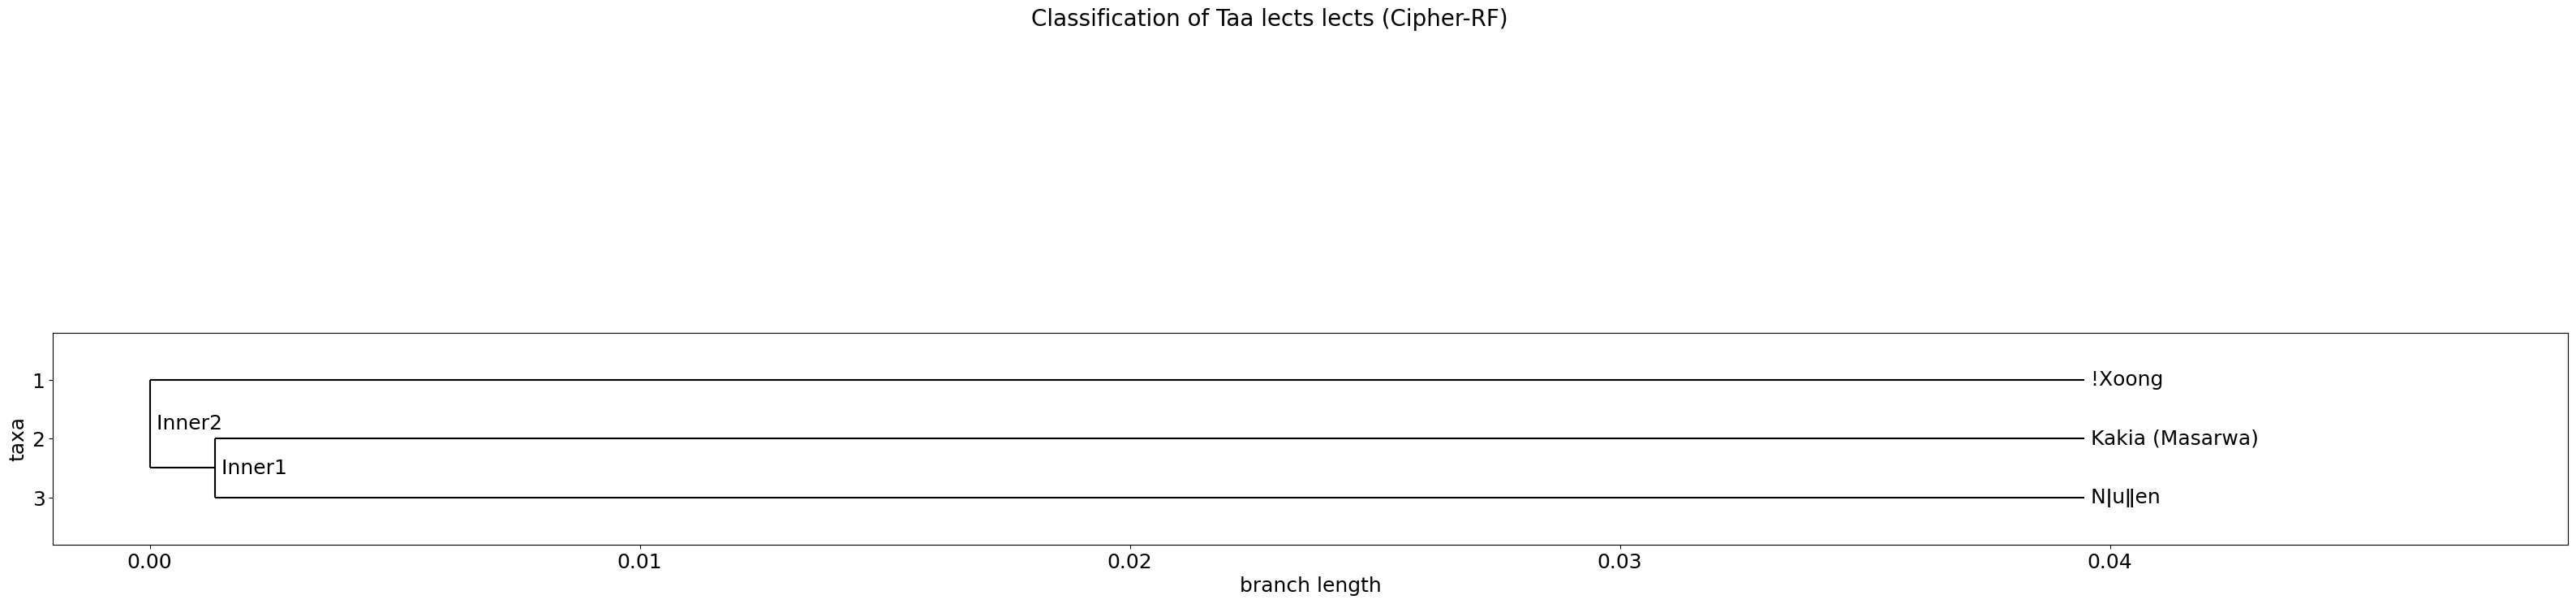

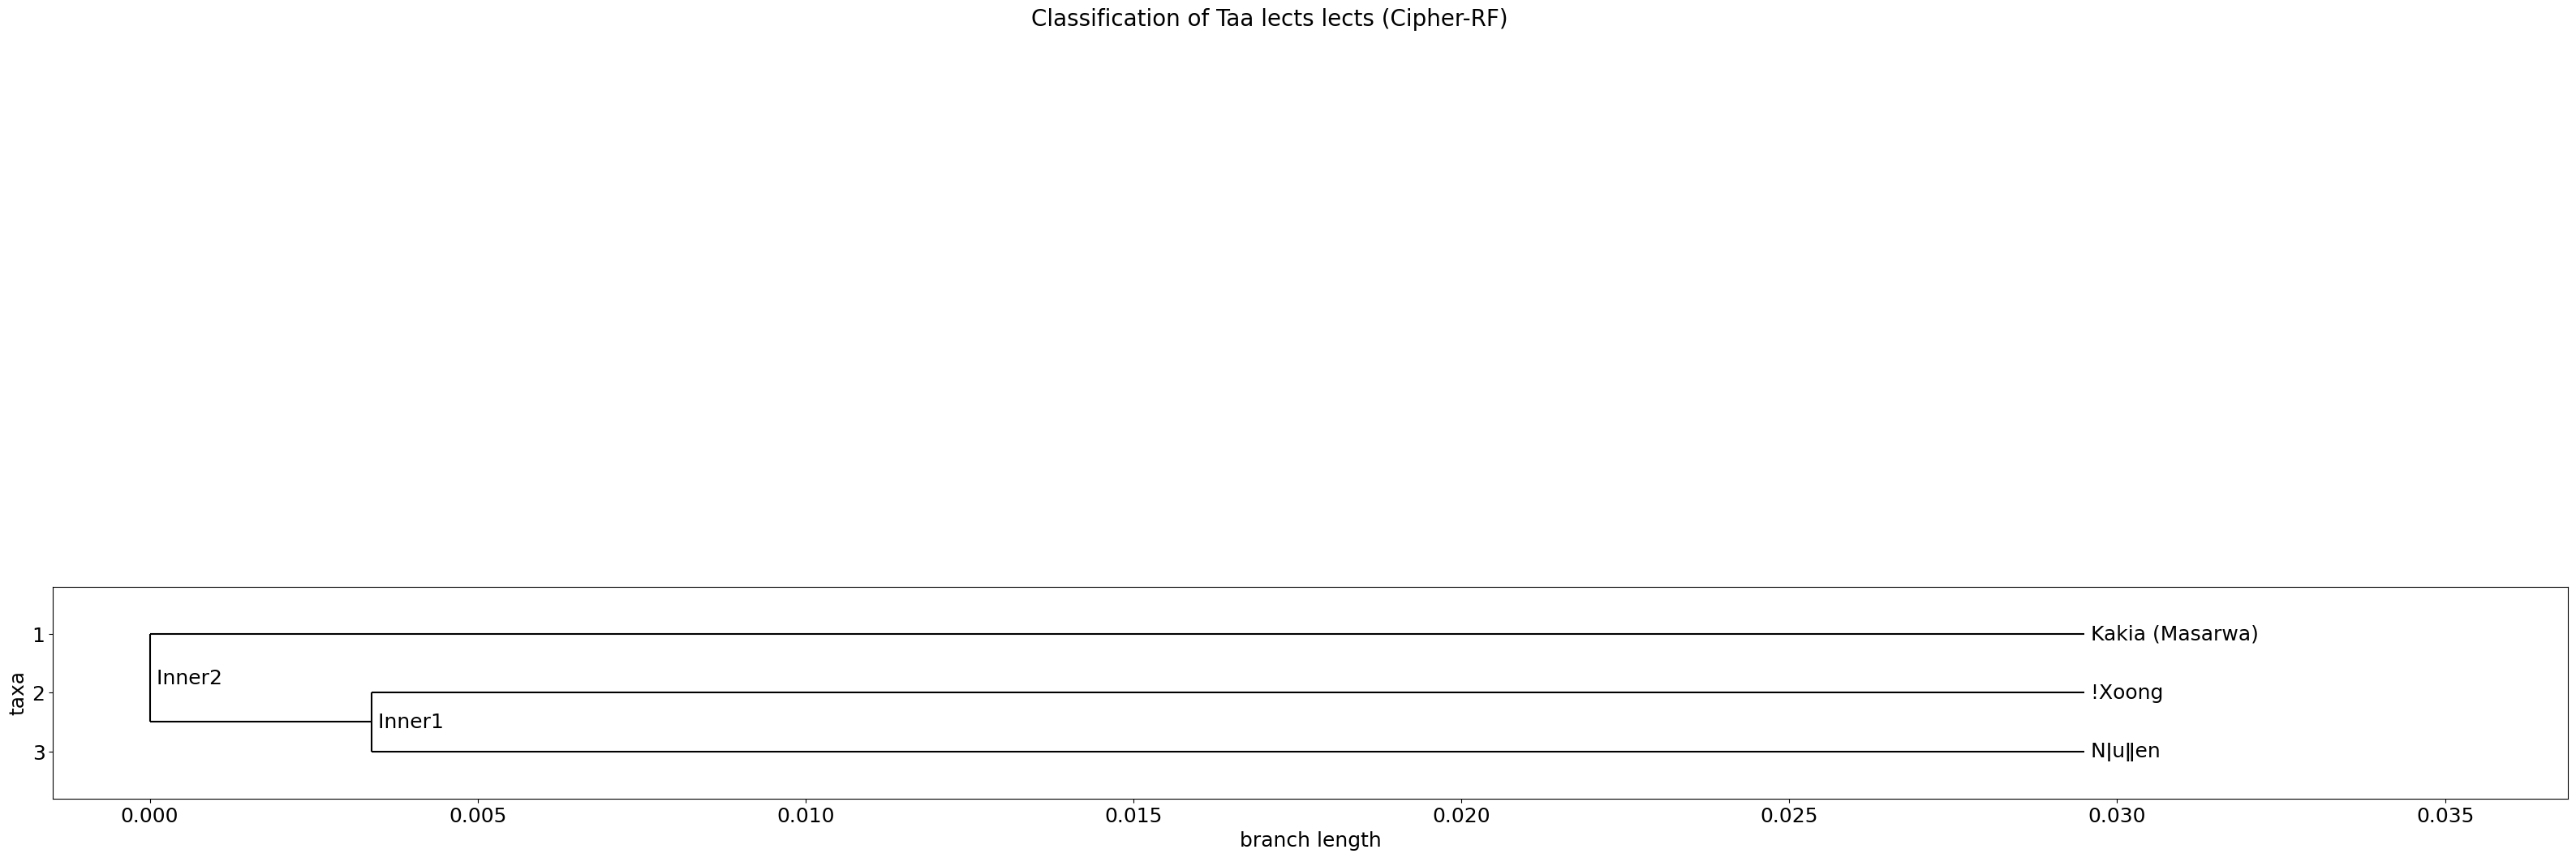

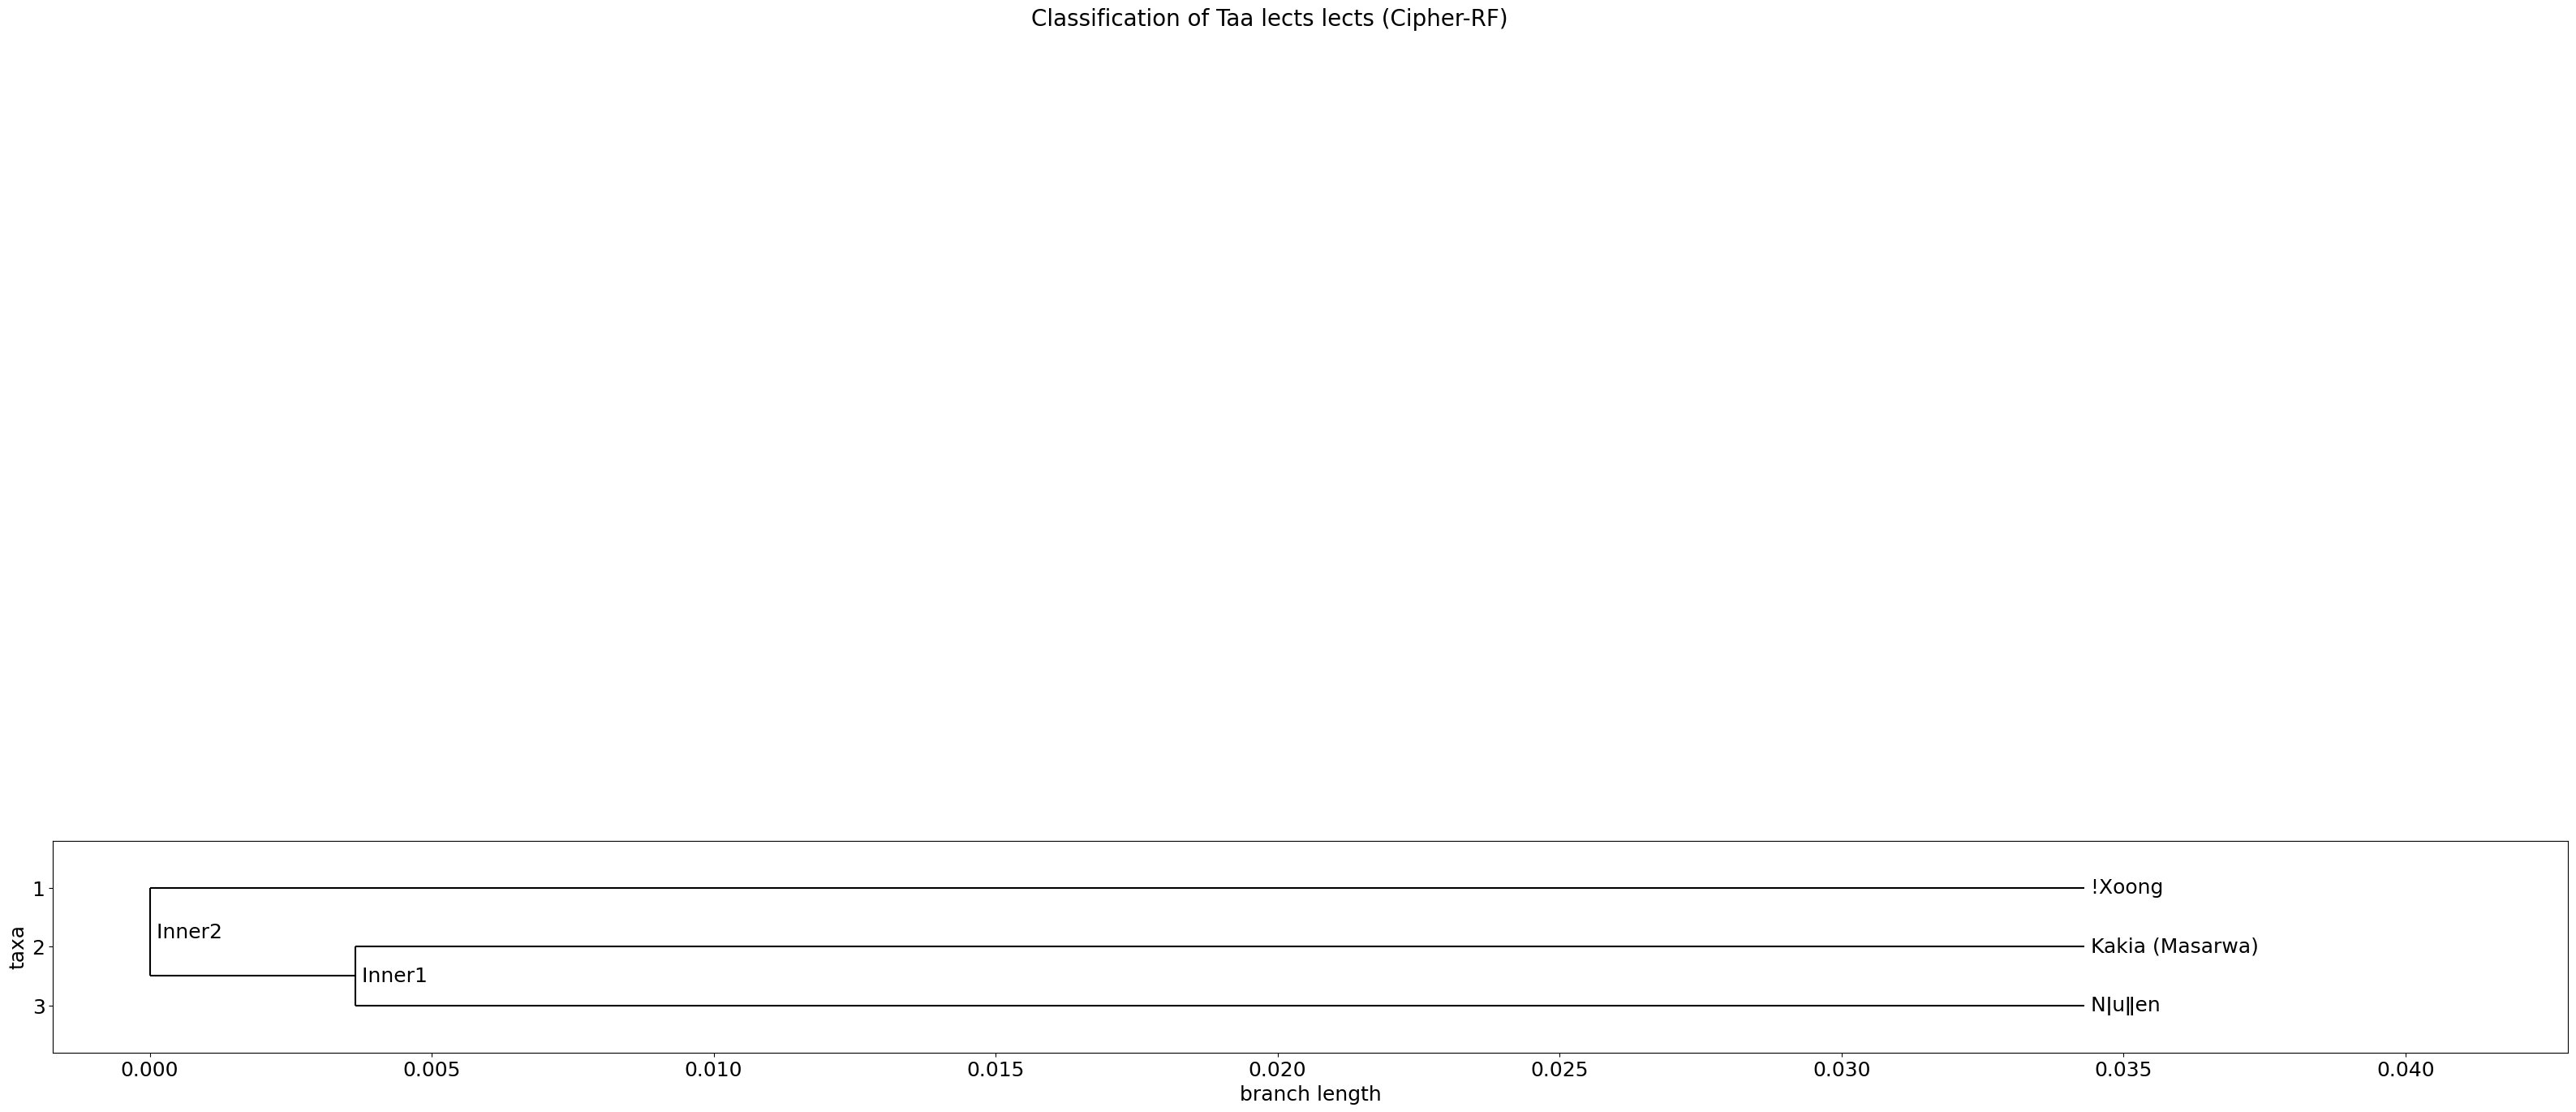

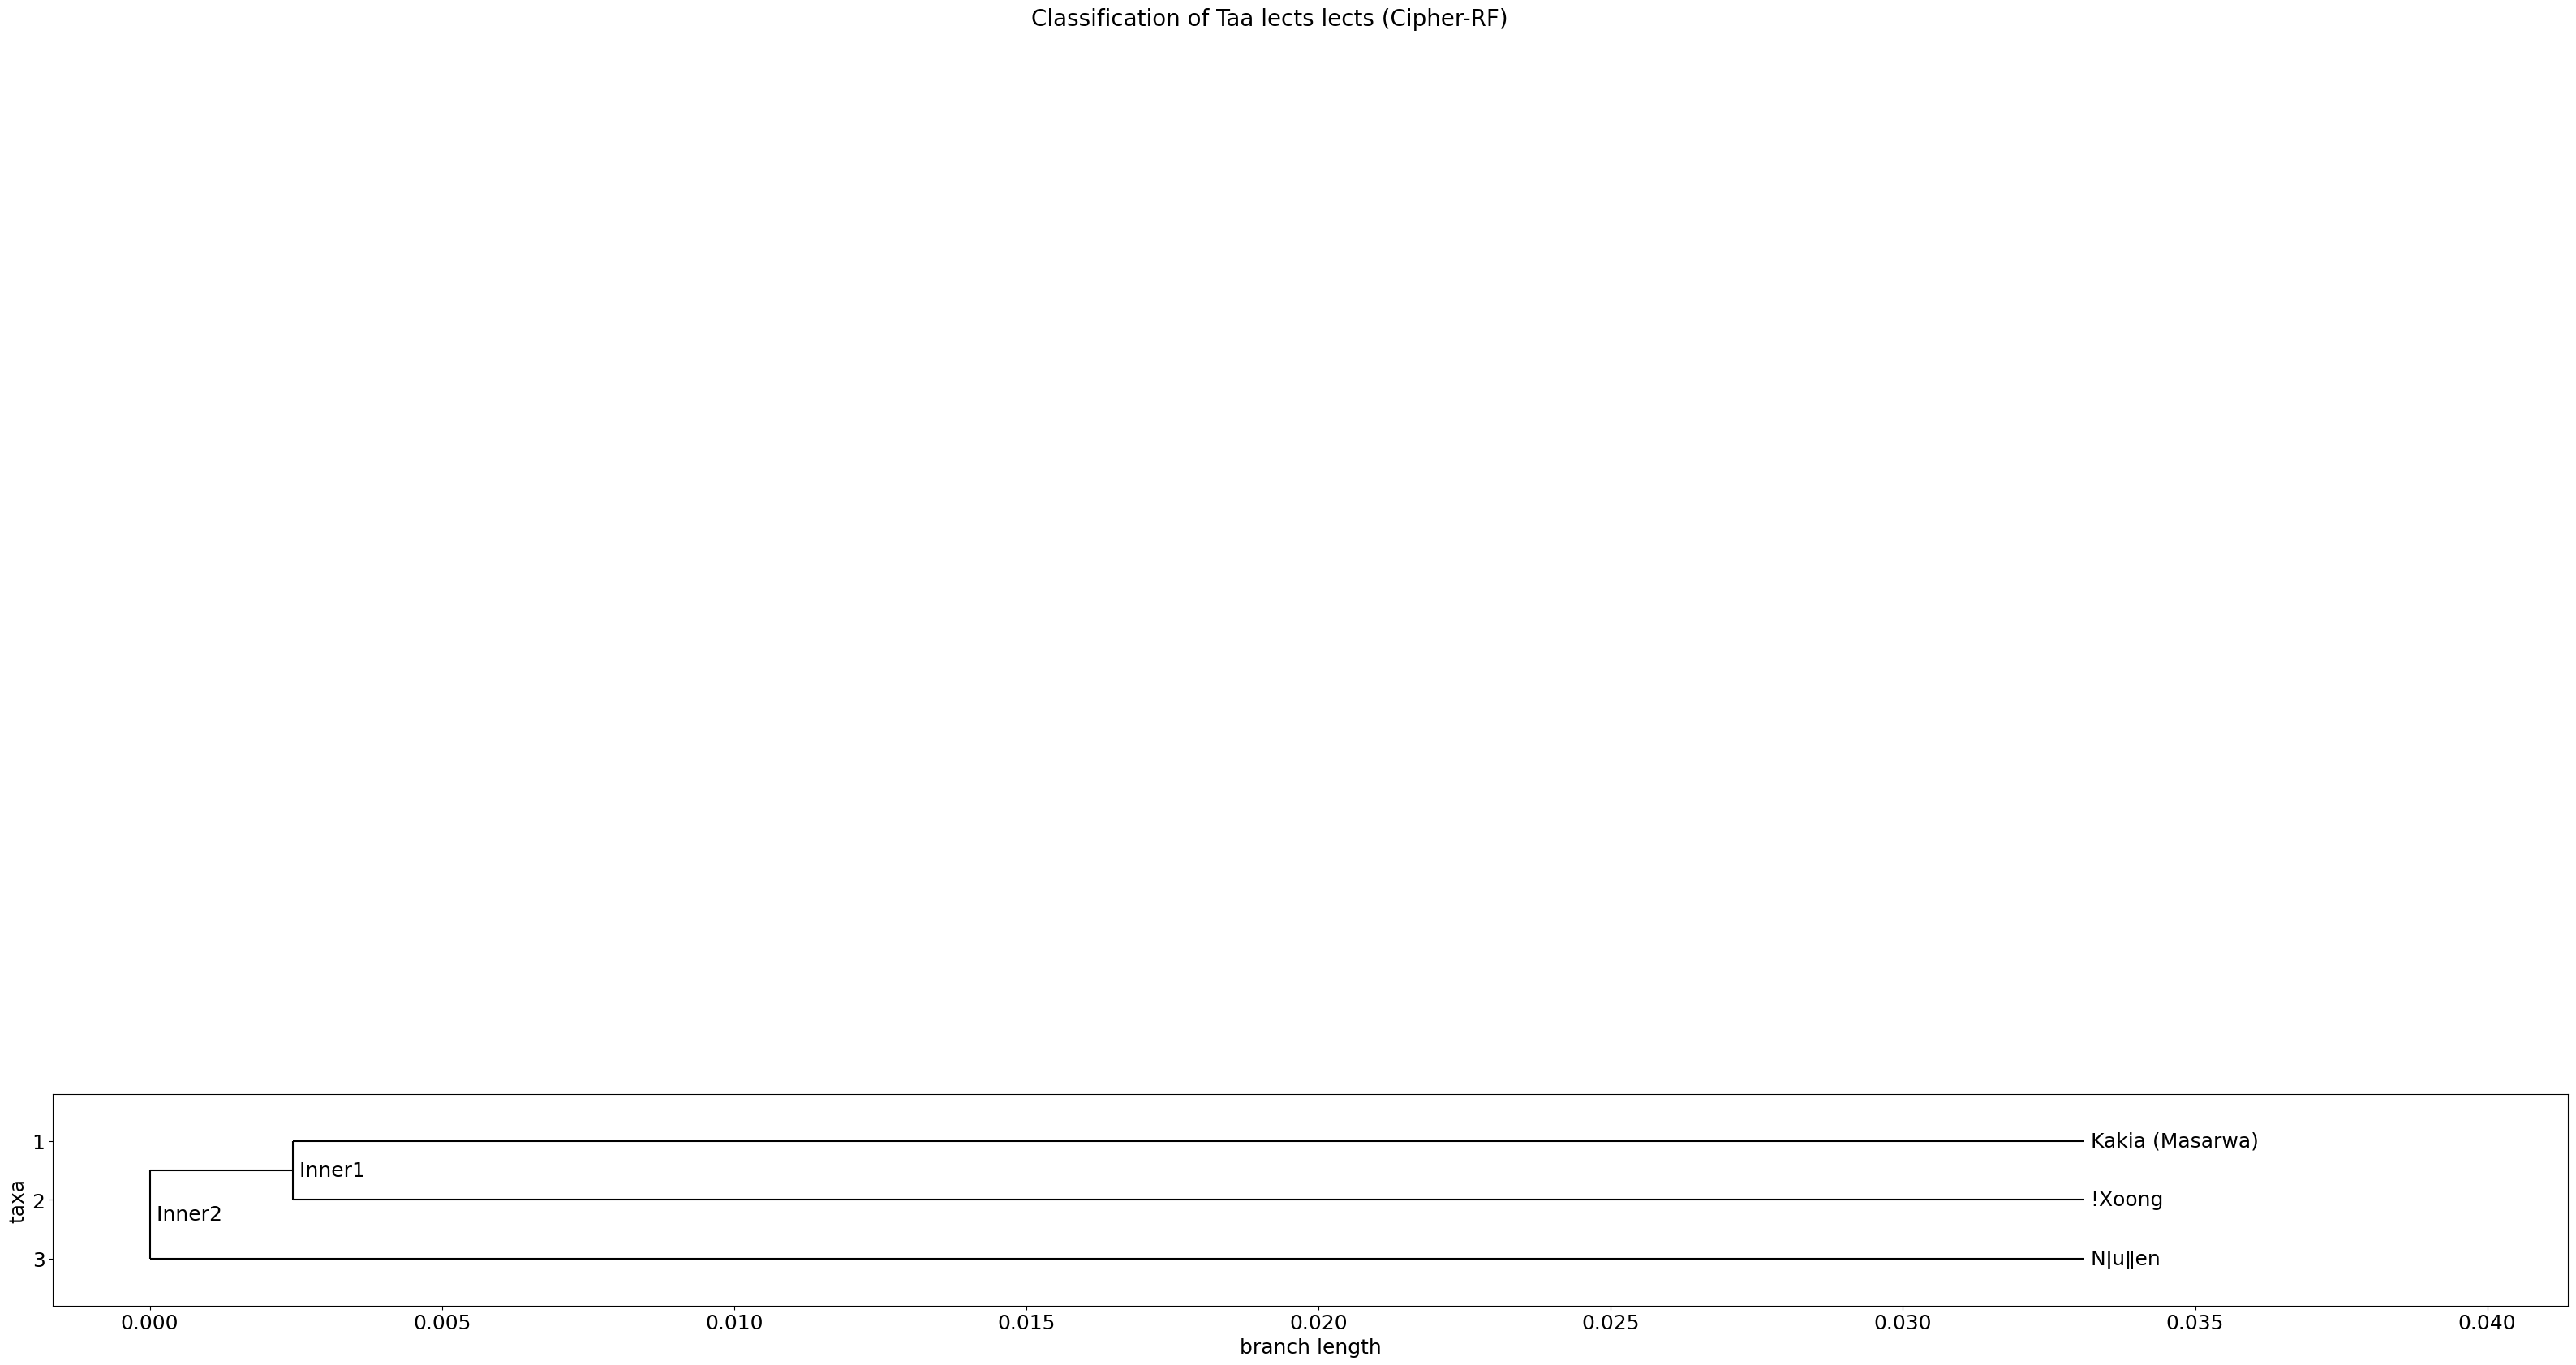

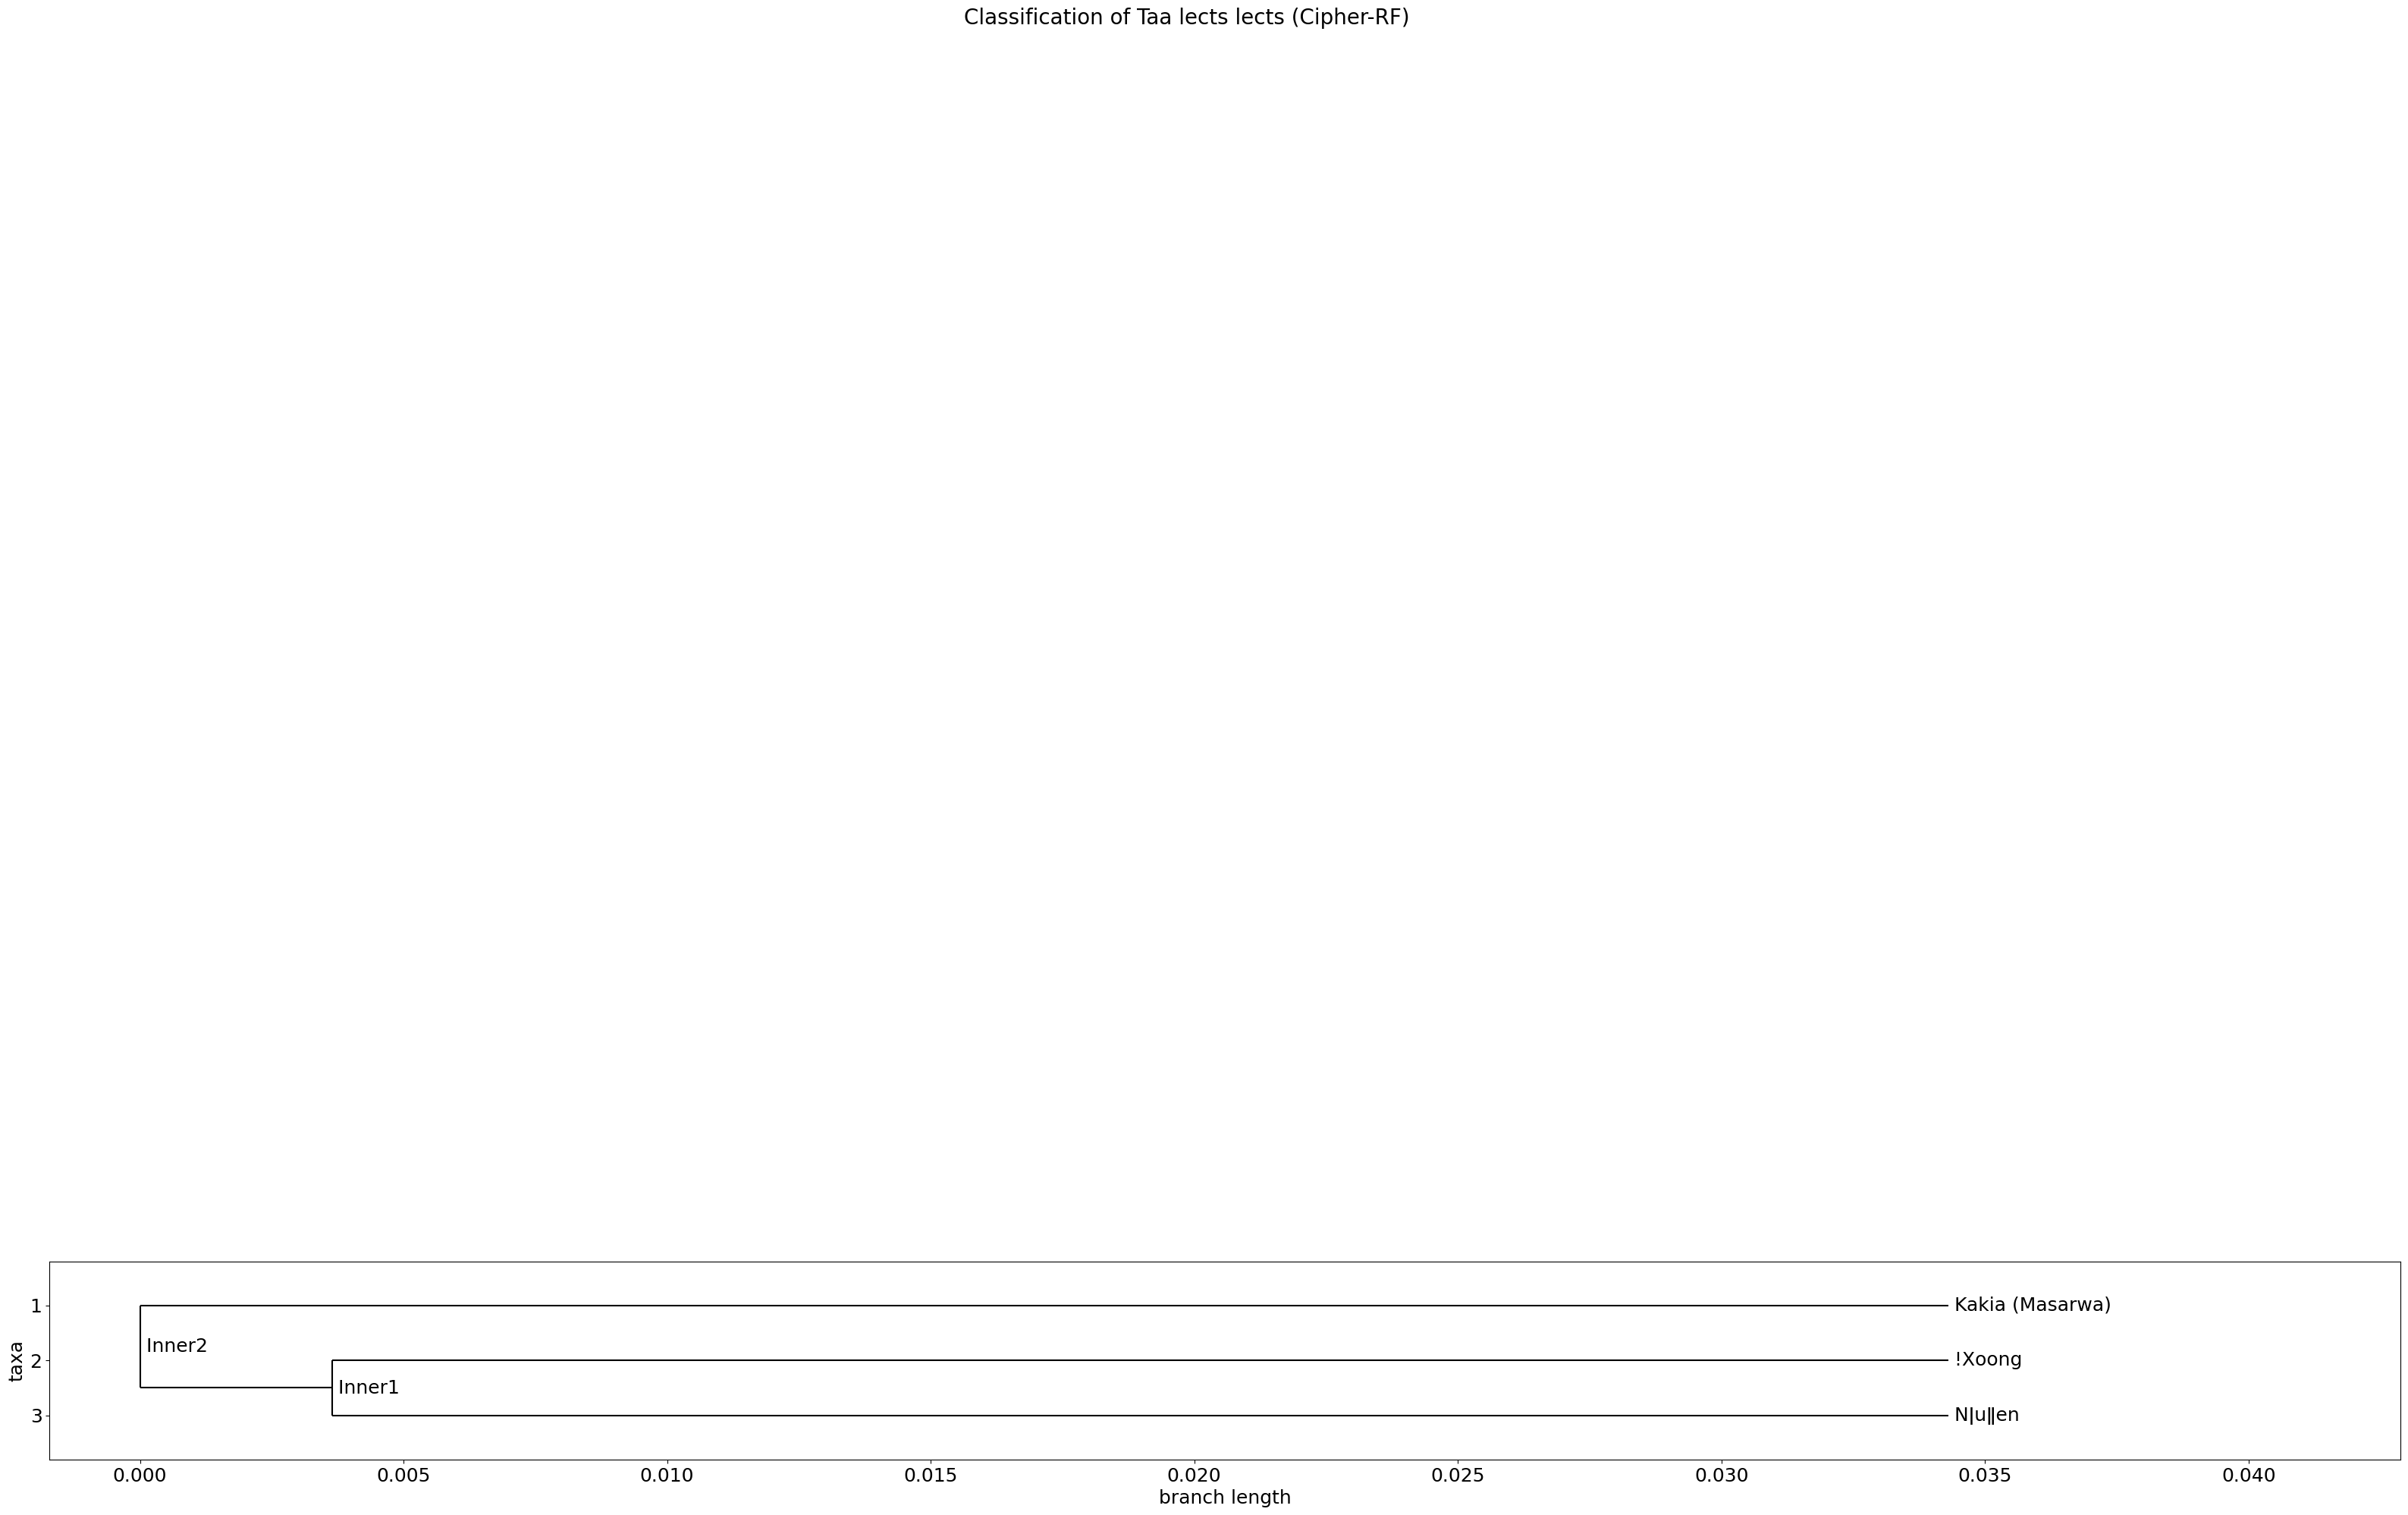

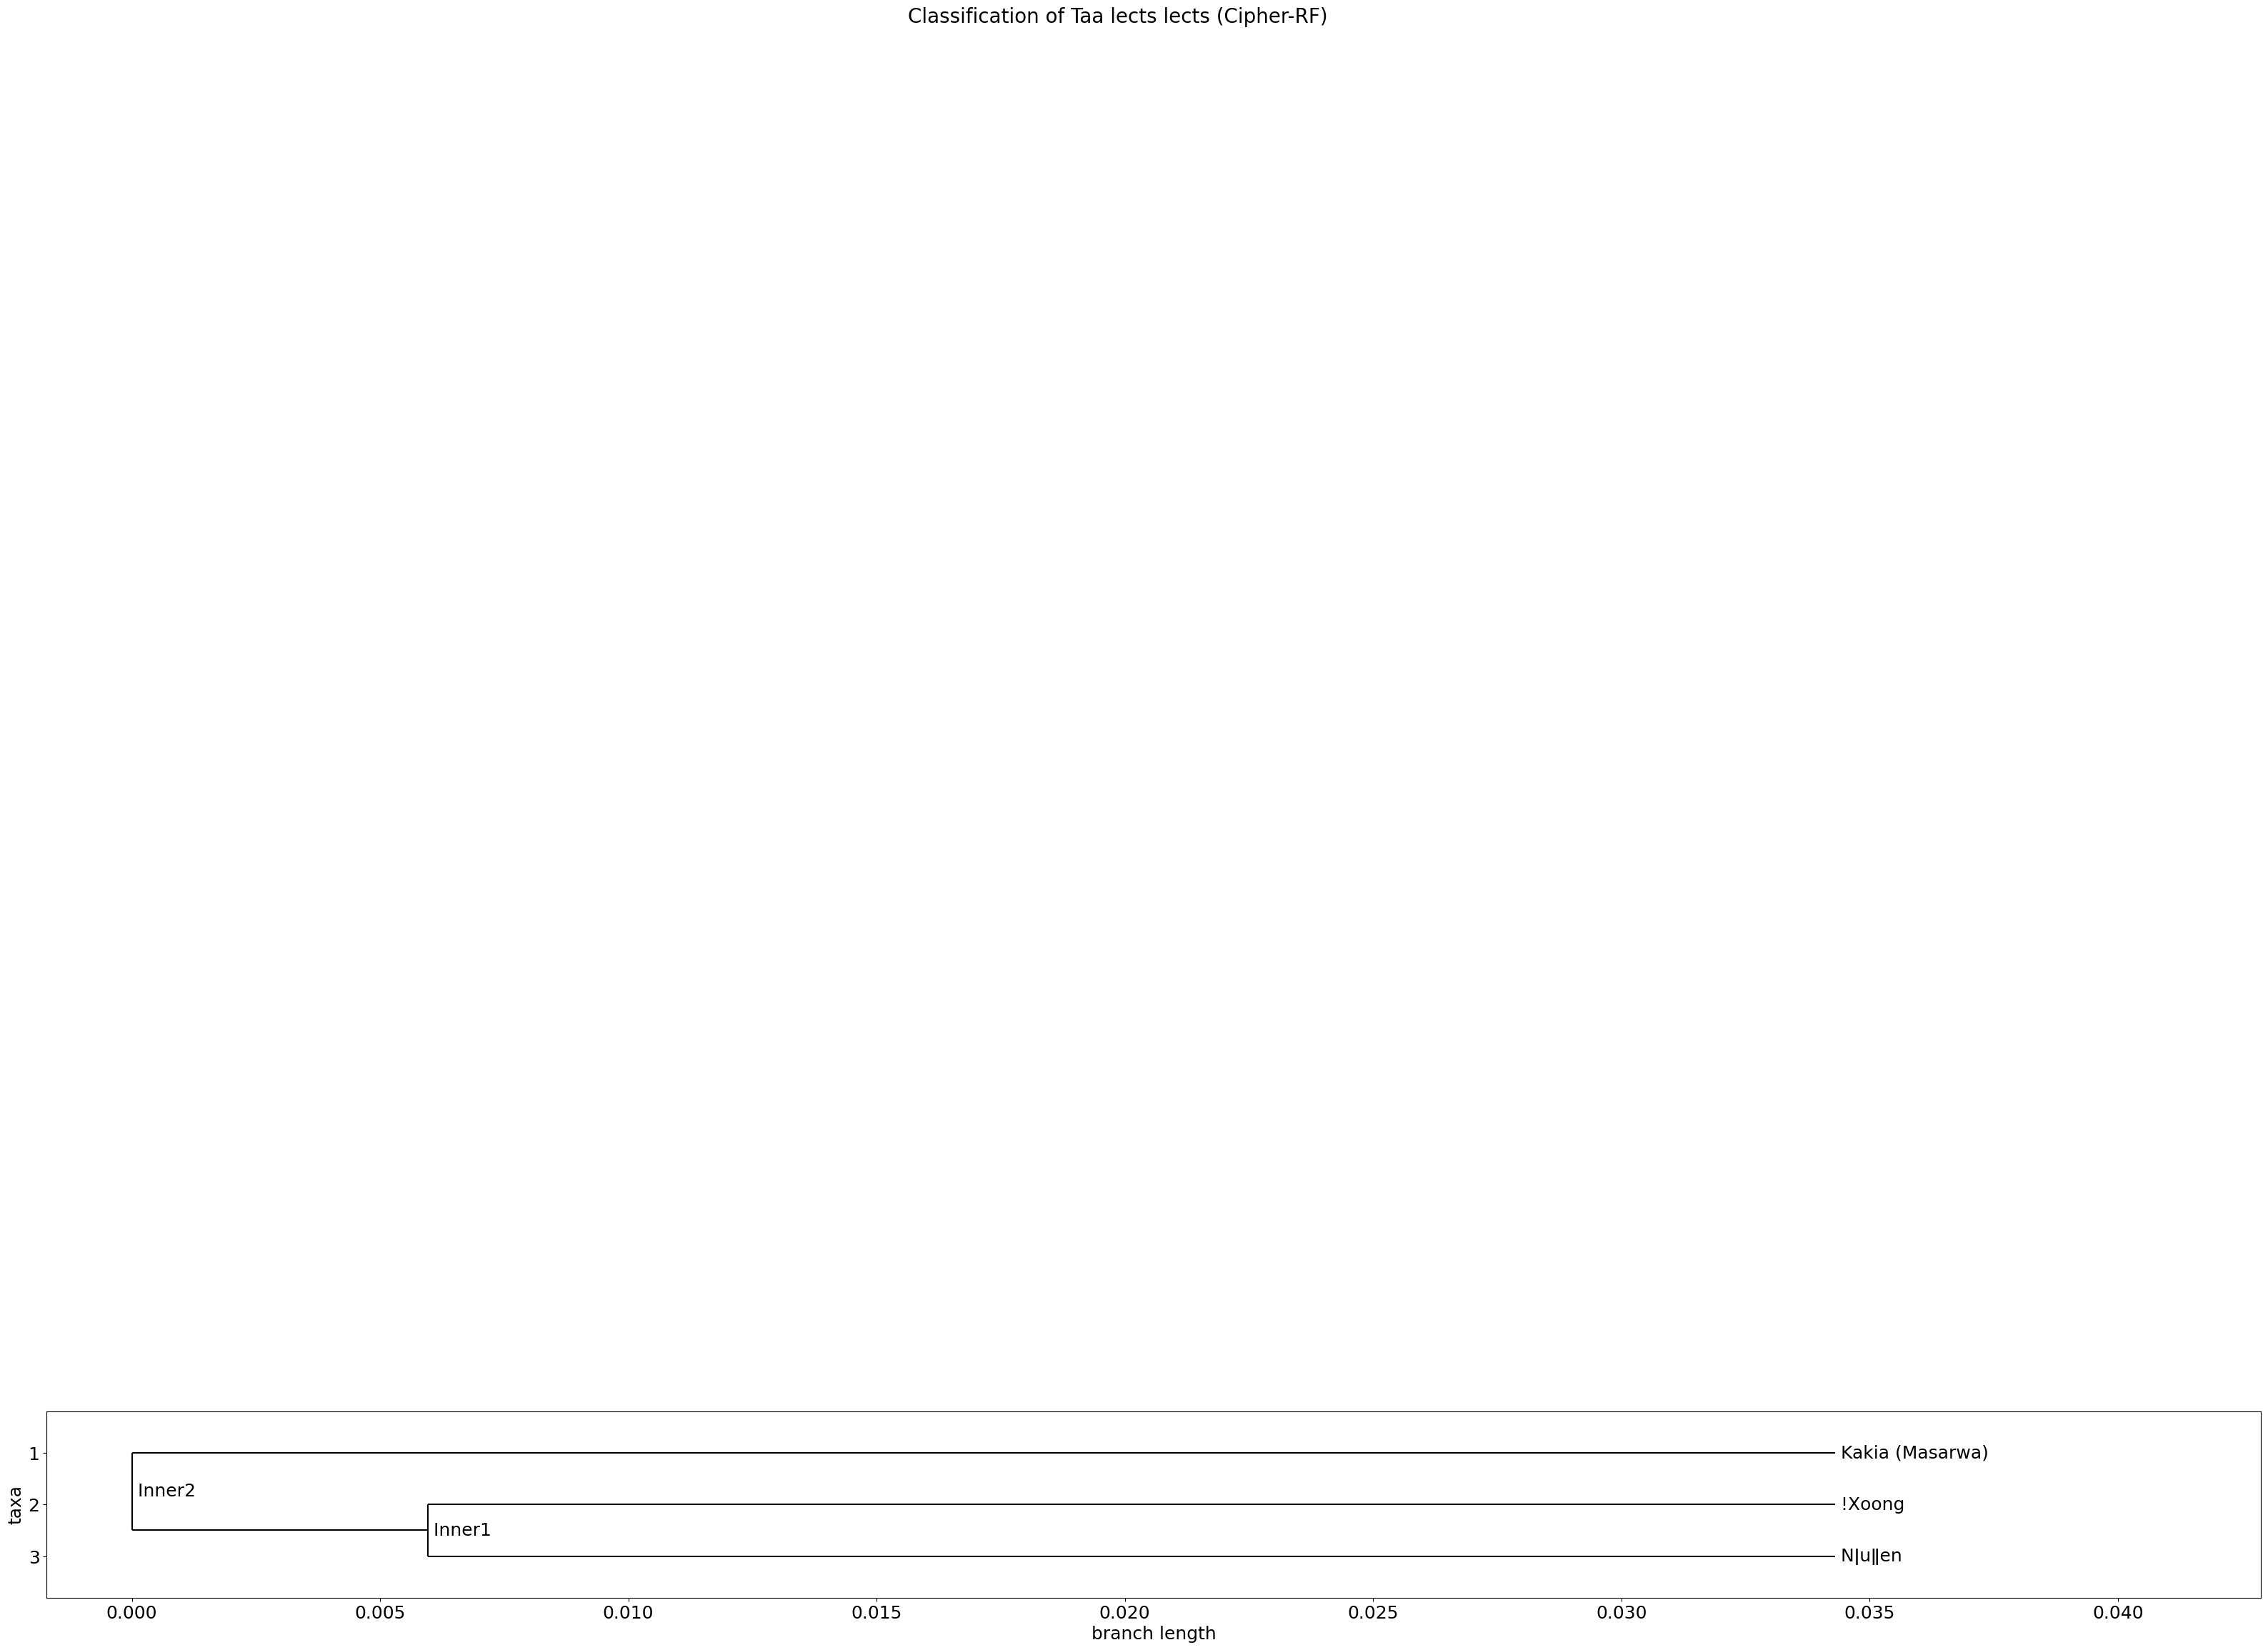

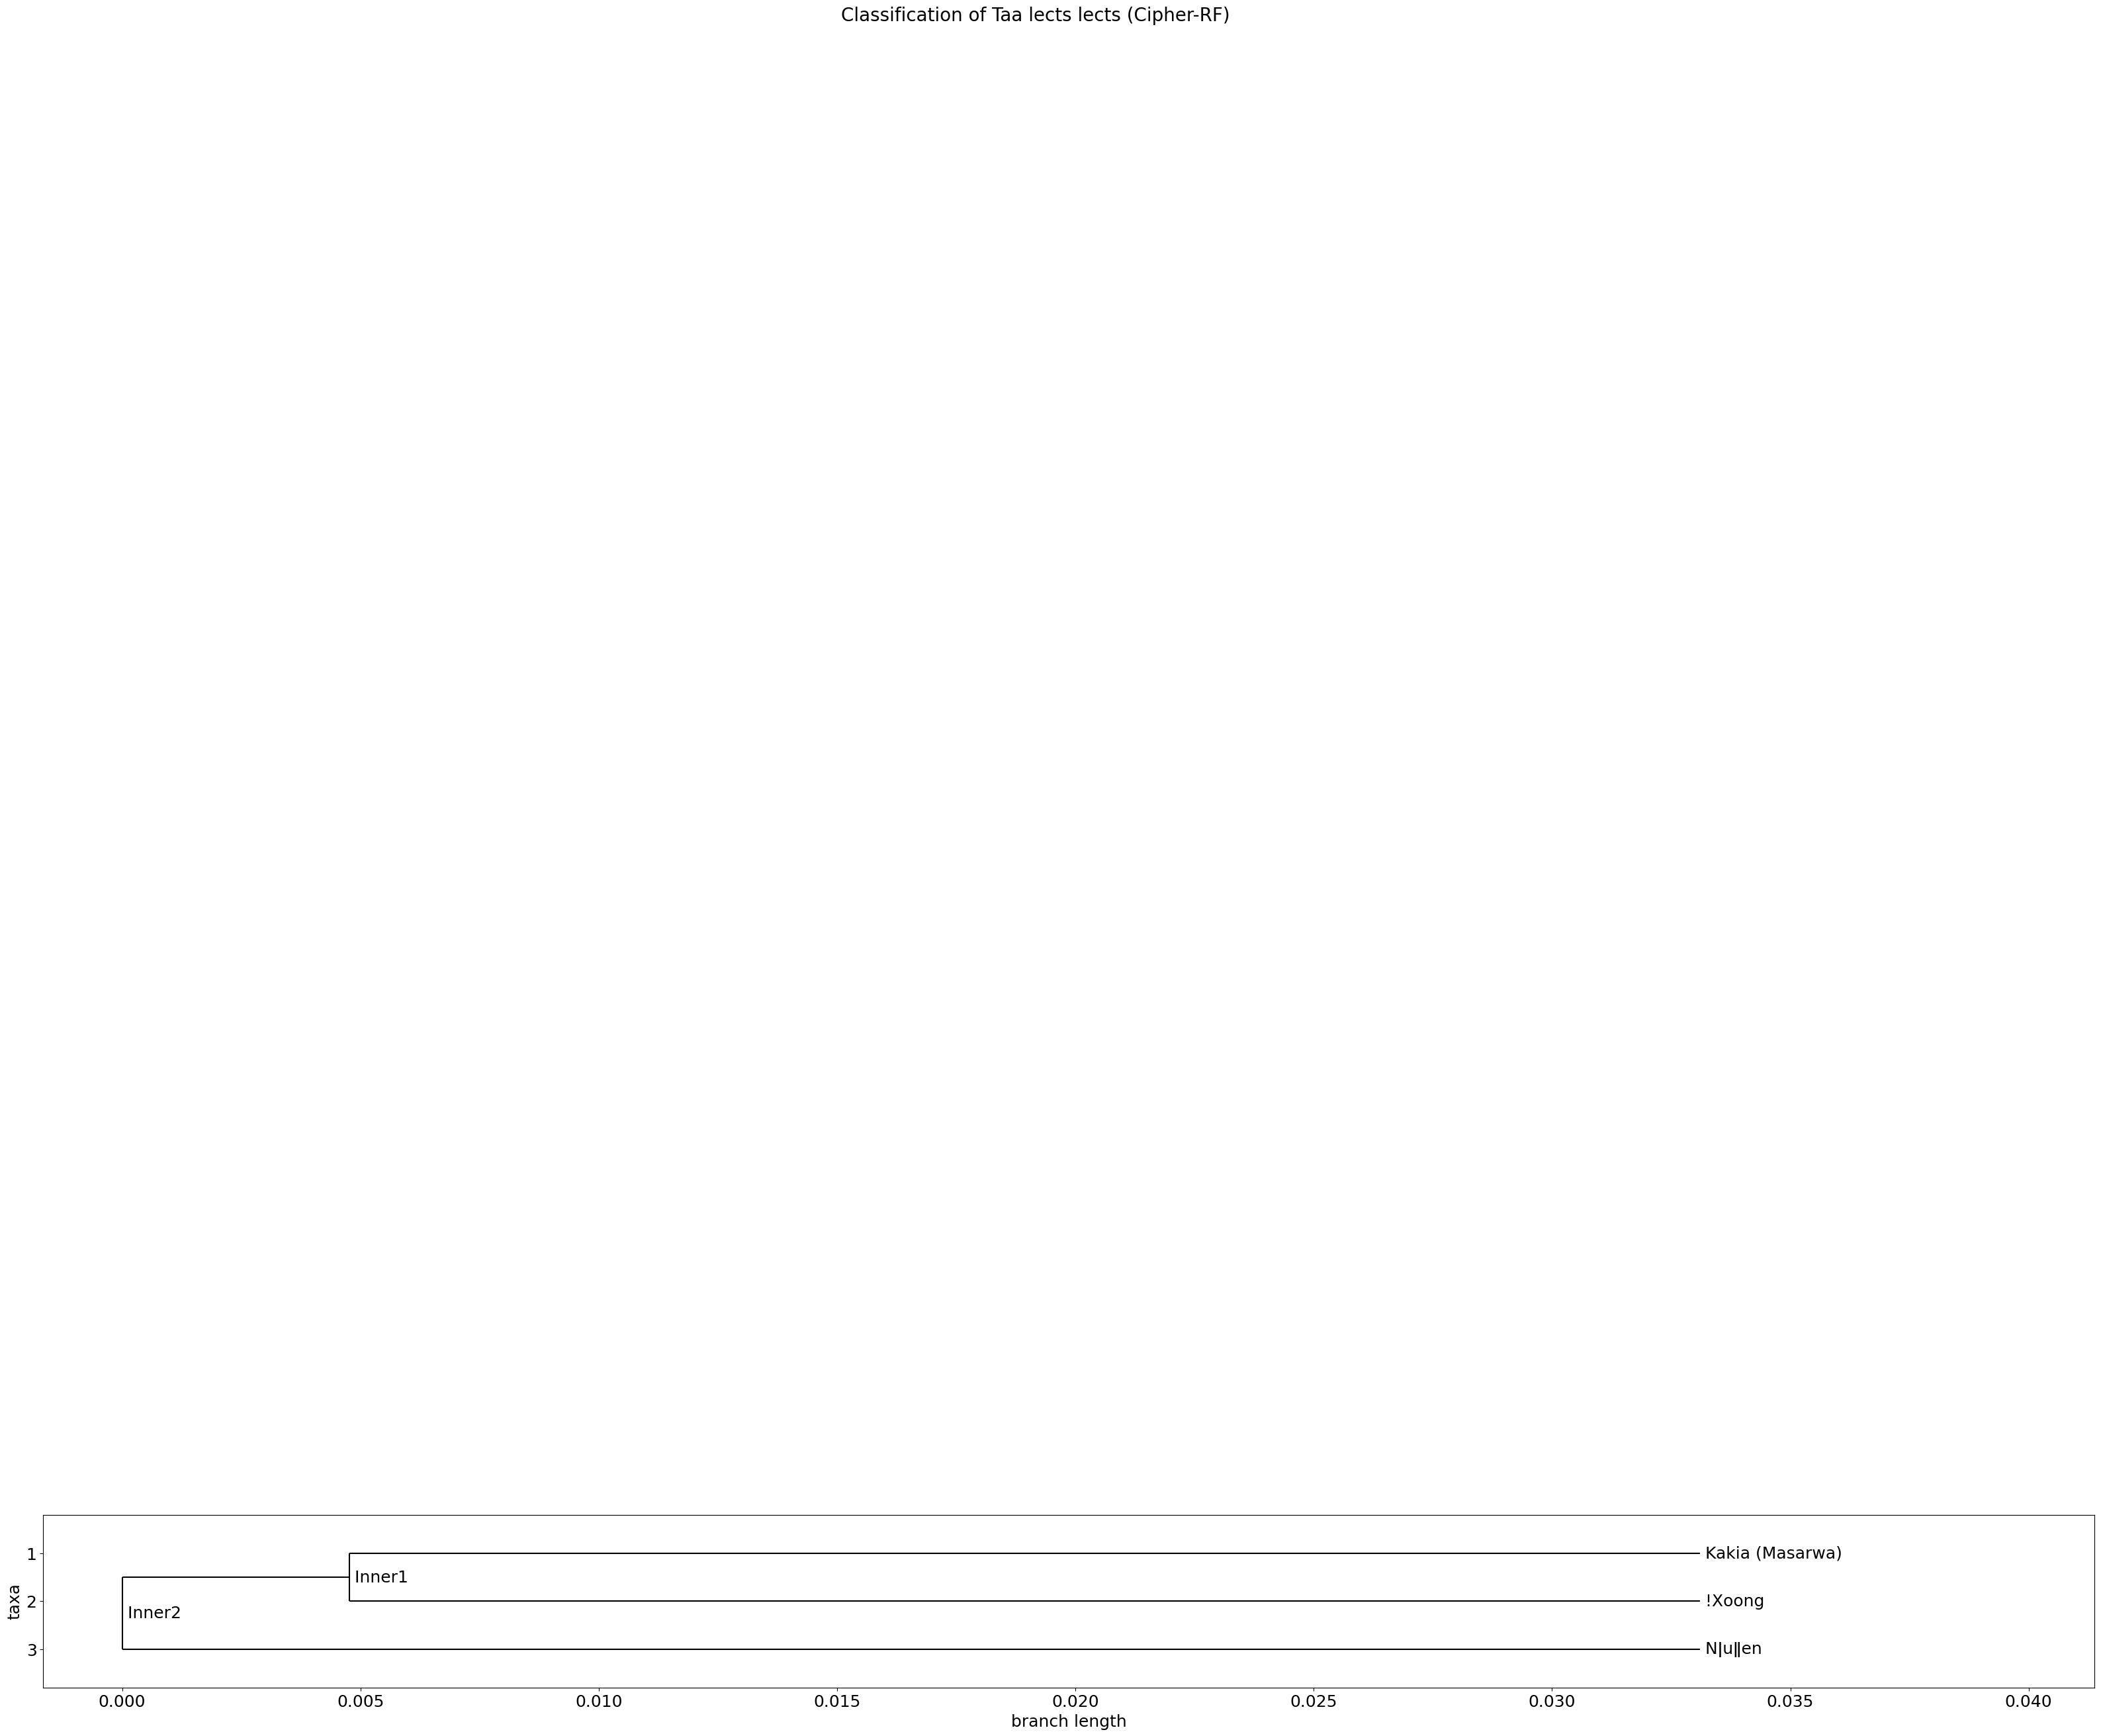

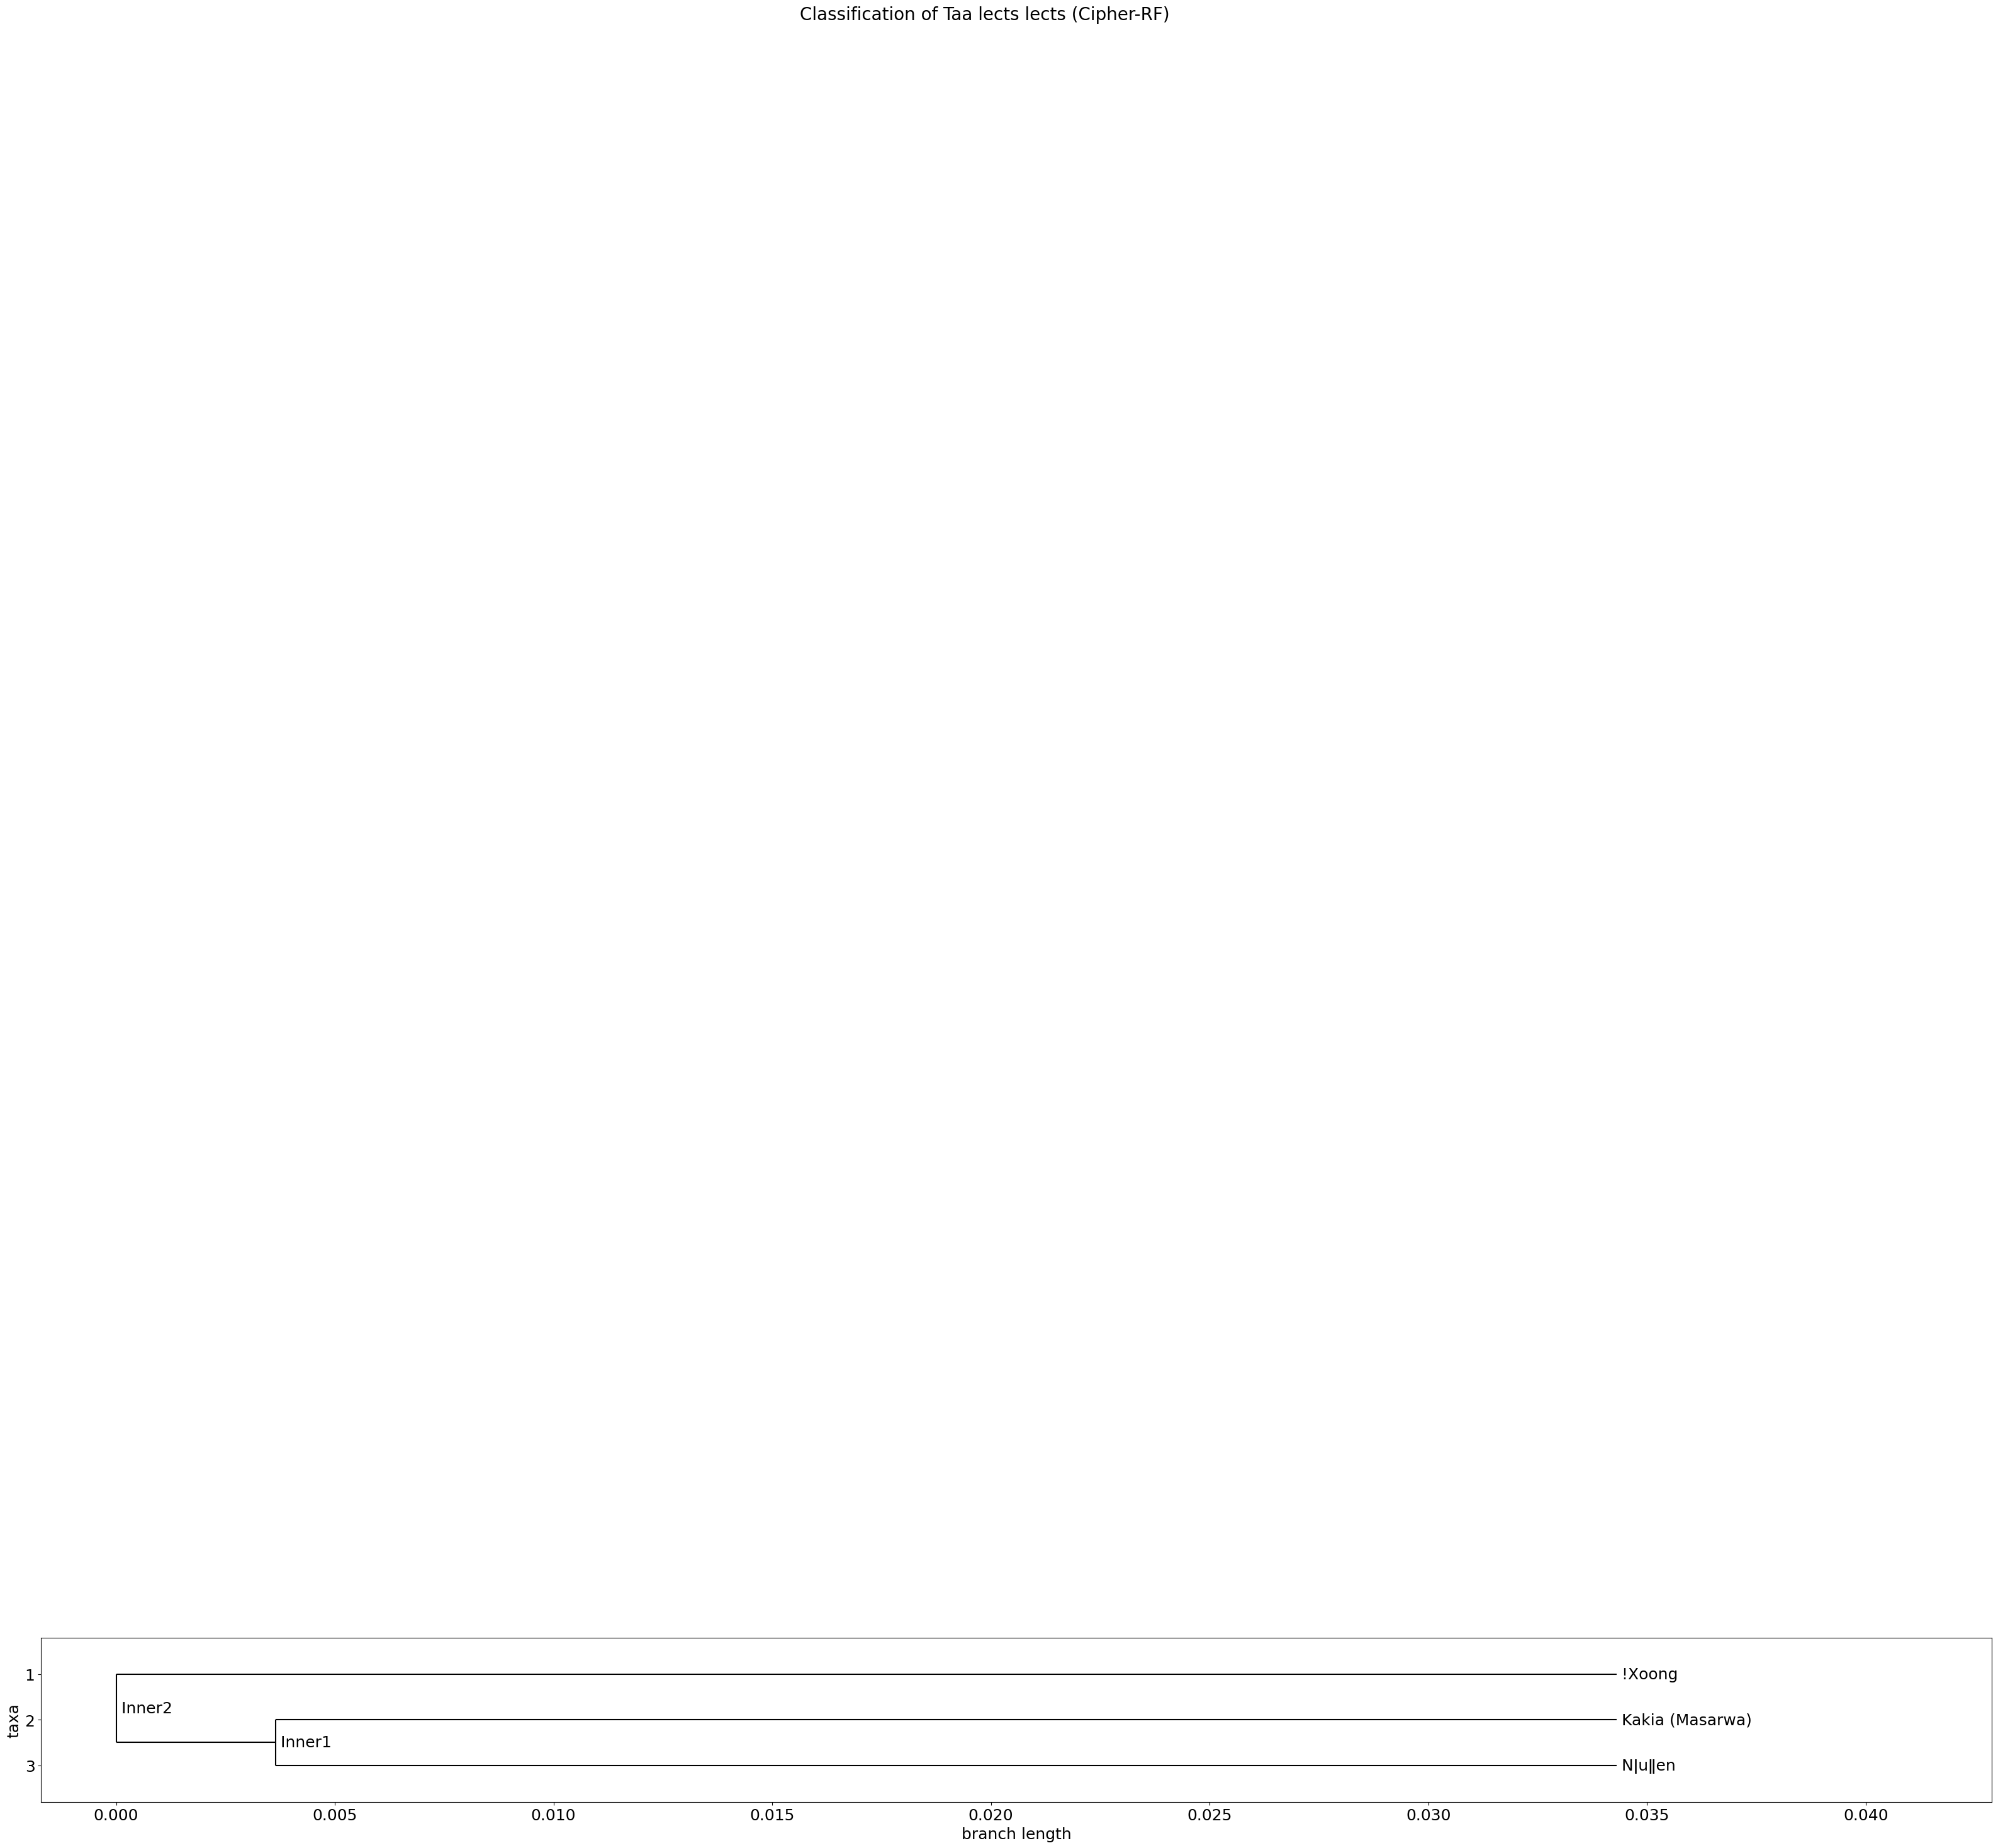

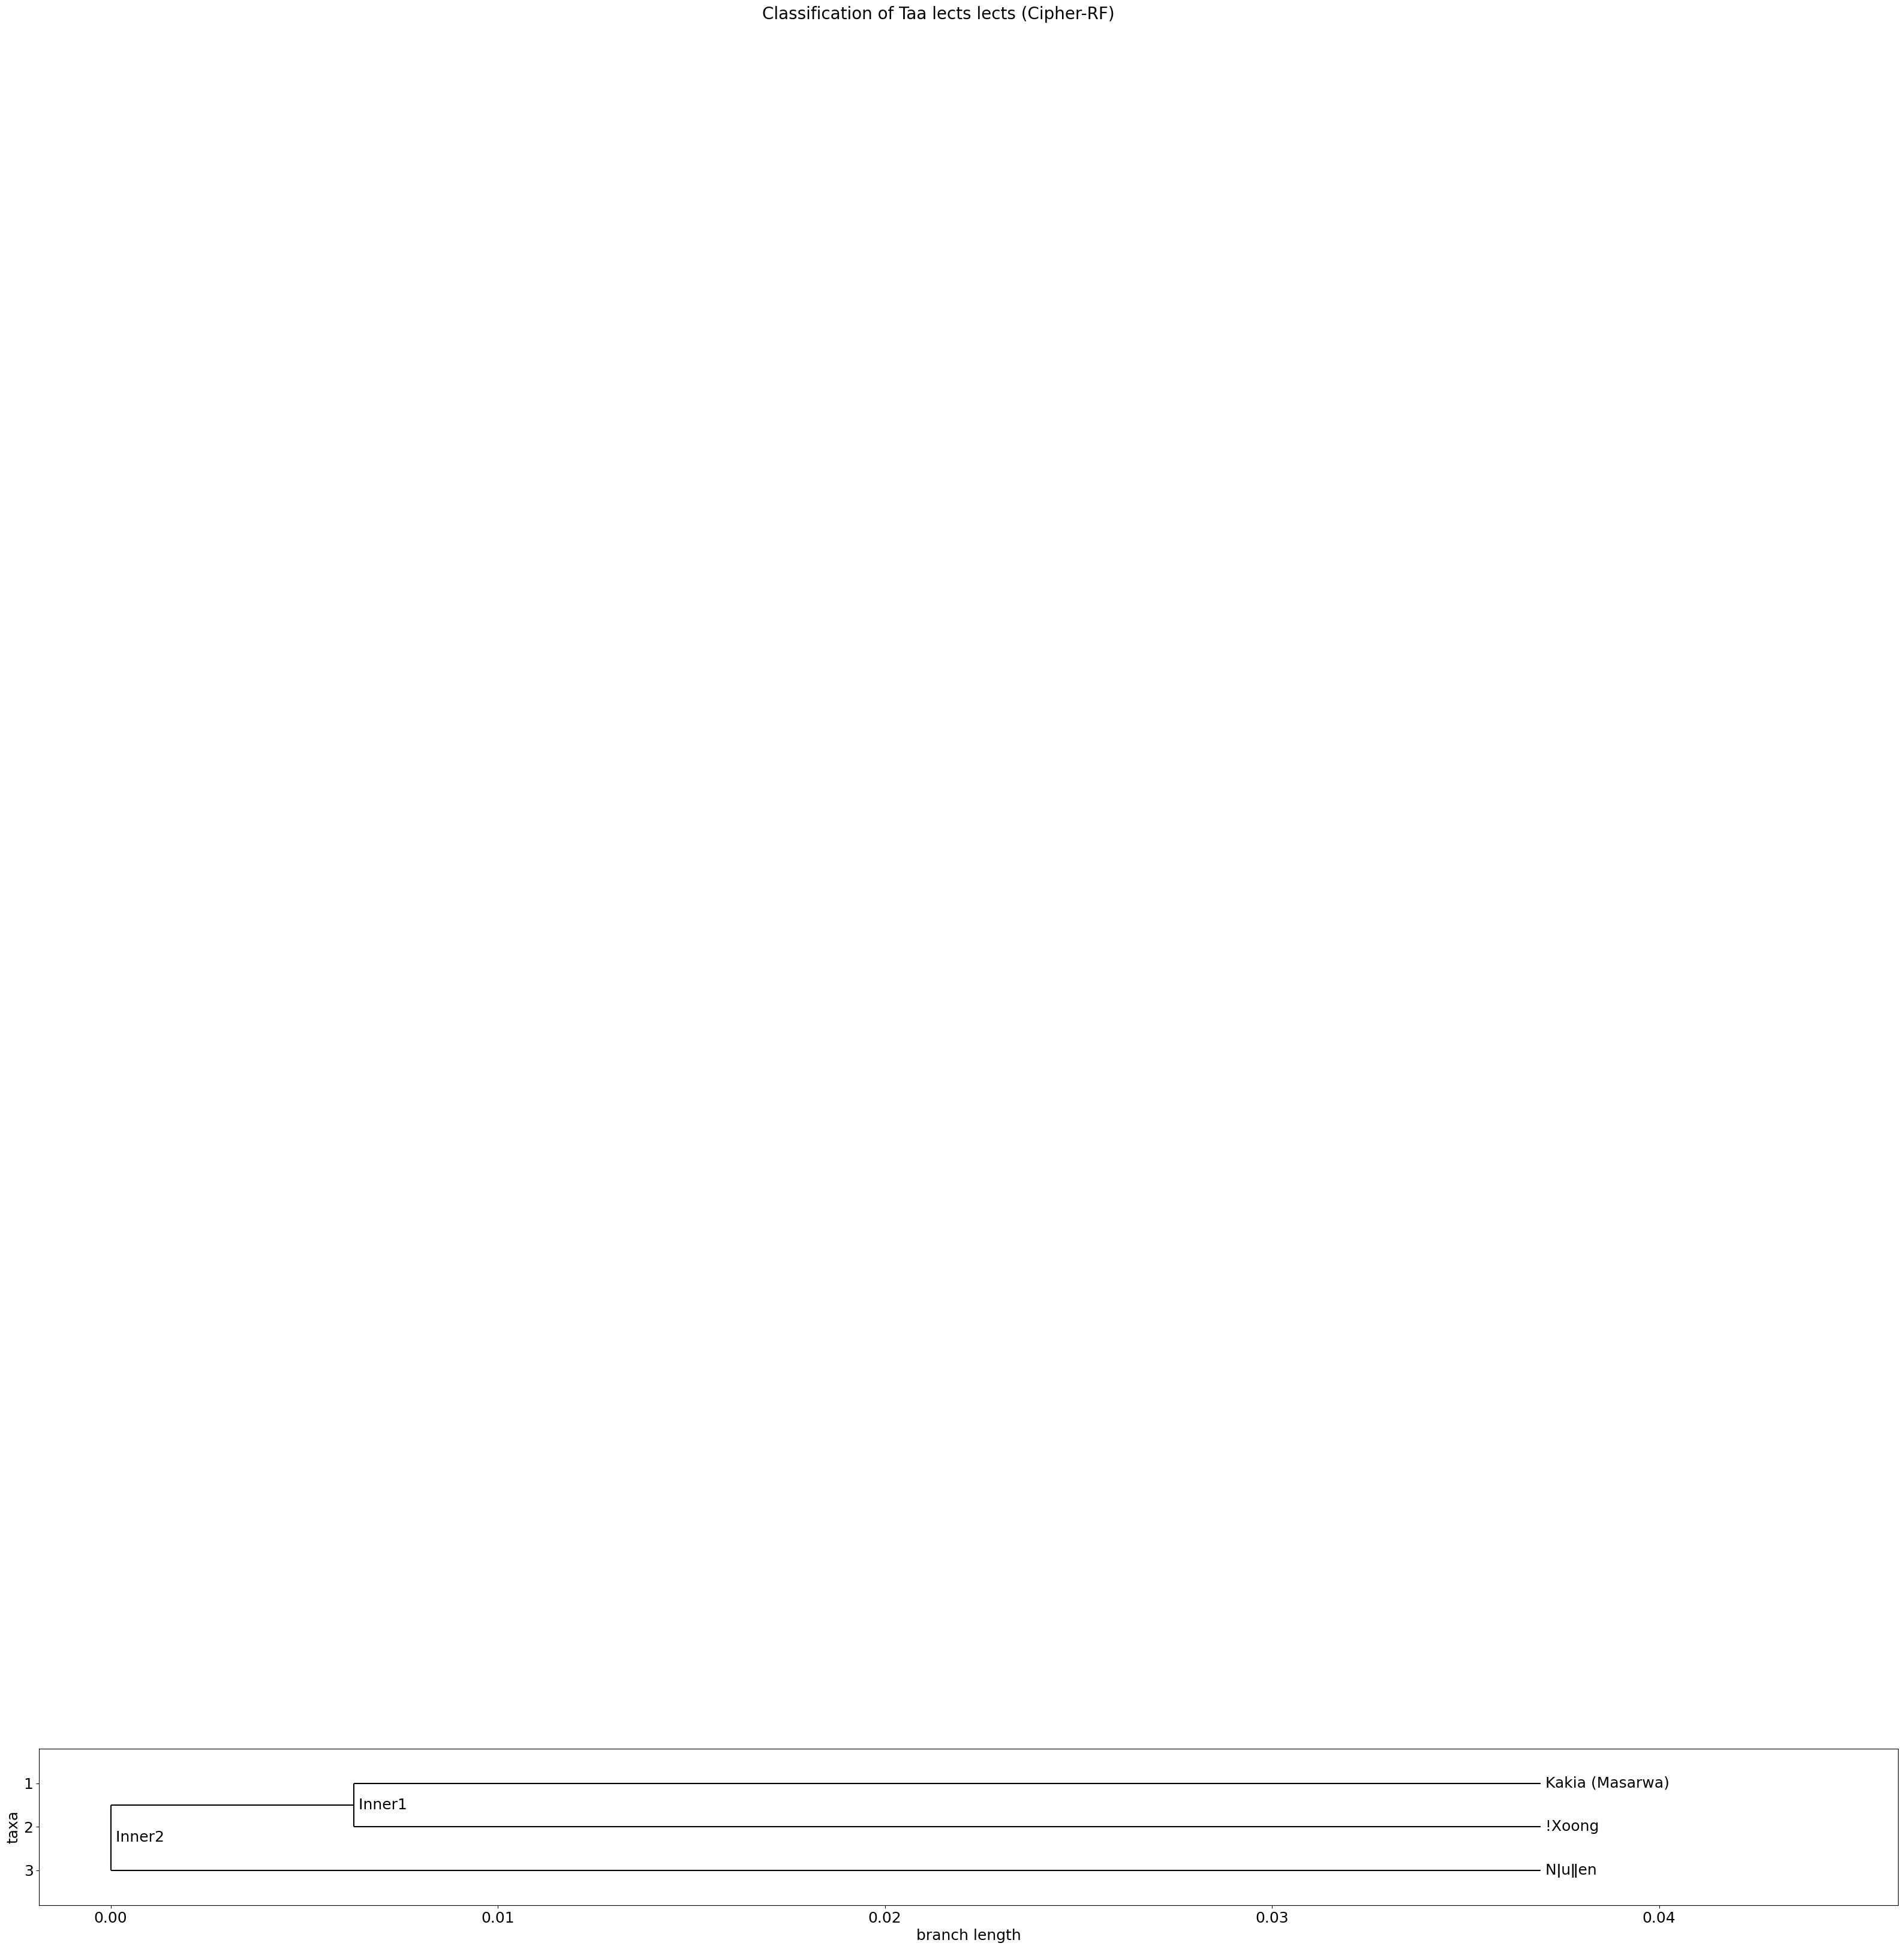

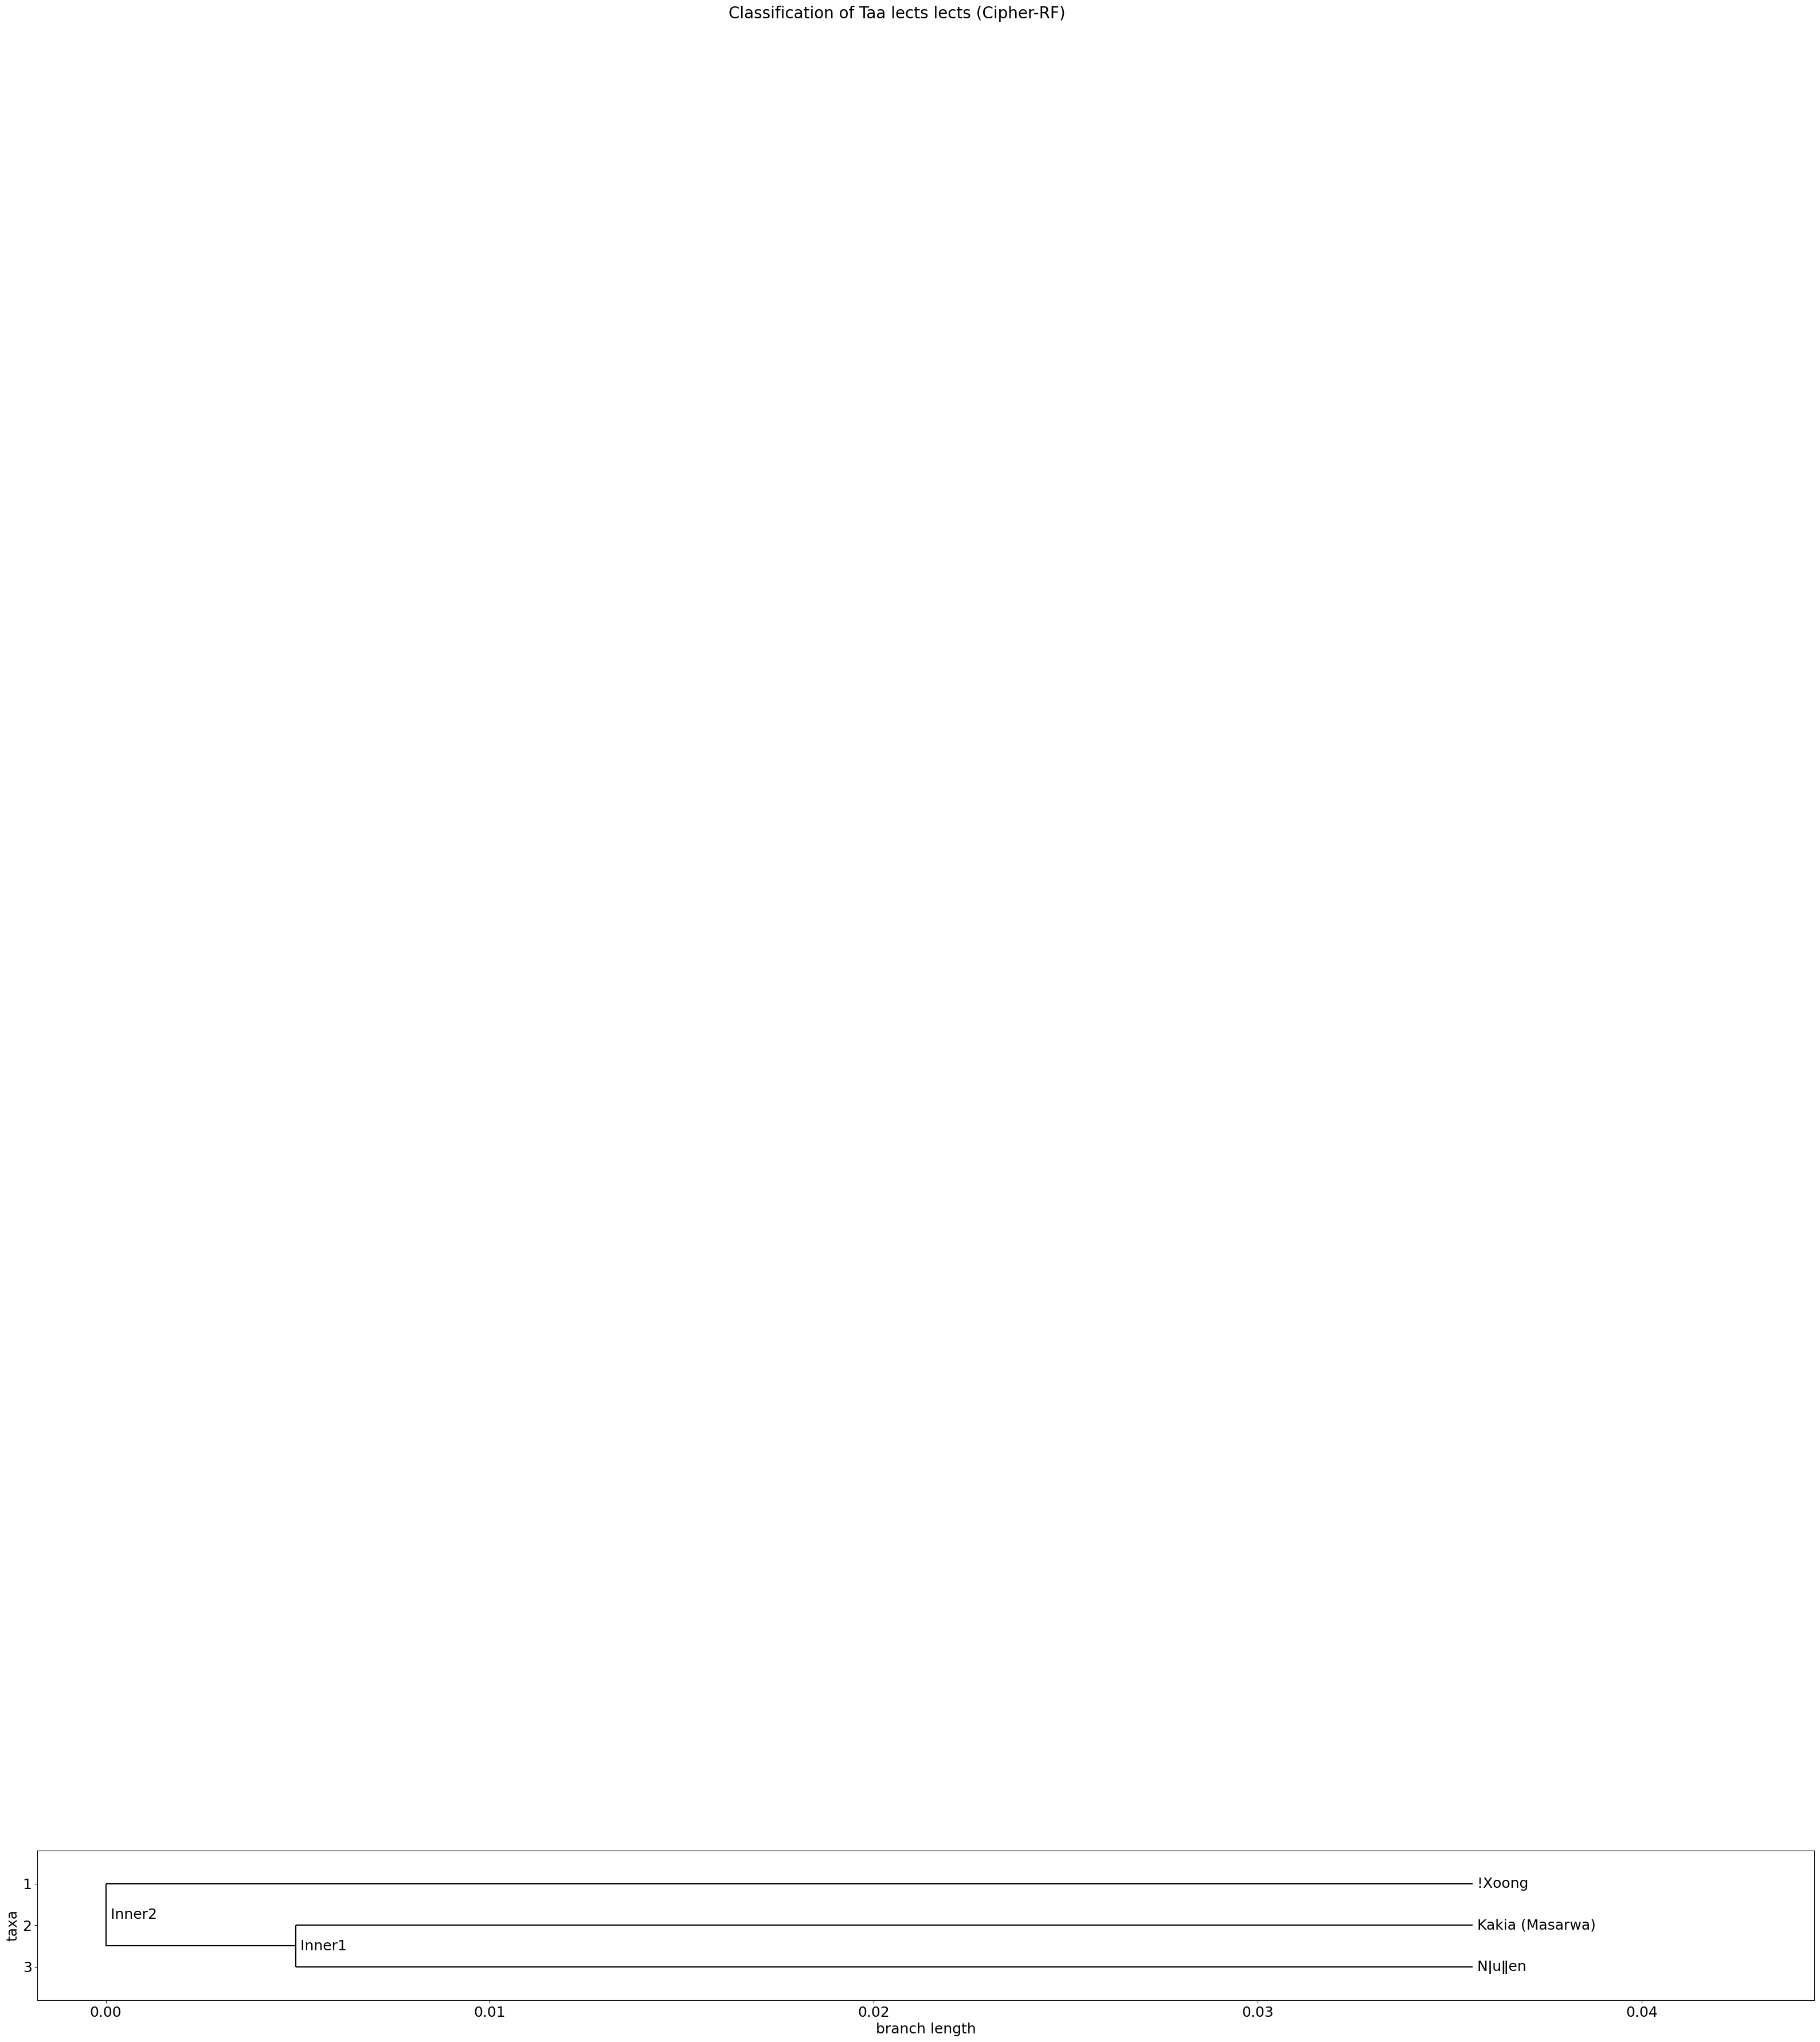

In [ ]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for this East Slavic lects does not differ in a drastic manner
for r in range(NUM_RUNS):
  names = [str(i) for i in list(set(y))]
  lists_result = final_matrices[r]
  distance_matrix = _DistanceMatrix(names, lists_result)
  tree = constructor.upgma(distance_matrix)
  %matplotlib inline
  font = {'family':'DejaVu Sans', 'weight':'normal', 'size':18}
  matplotlib.rc('font', **font)
  fig = plt.figure(figsize=(40, 40))
  fig.suptitle(f'Classification of {DATA} lects (Cipher-RF)', fontsize=20)
  axes = fig.add_subplot(NUM_RUNS, 1, r + 1)
  Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
  plt.savefig(f'phylogeny_black_box_{DATA}_run_{r}.png')
  plt.show()

# Method cross-evaluation: string similarity measures

String similarity measures are a simple method that is often used in computational phylogenetic linguistics. We use different string similarity measures with different efficiency and explainability degree.

## Levenshtein distance

Levenshtein distance normalised divided (LDND) is the most traditional string similarity measure for computational phylogenetic linguistics. It scores additions, deletions and substitutions between two strings. We then normalise it by the length of the bigger word in pair. The metric present distance between lects as a mean of normalised Levenshtein distances.

In [ ]:
pairwise_distances = []
for i in tqdm(unique_pairs):
  neutral_lects = get_non_relevant_pairs(i, df_pairs)
  # get data for pair under consideration
  lect_1 = df[df['lect'] == i[0]]
  lect_2 = df[df['lect'] == i[1]]
  # get all the concept
  concepts = list(lect_1['concept'].unique())
  concept_distances = []
  # for each concept, we calculate normalised Levenshtein distance
  for c in concepts:
    concept_in_lect_1 = lect_1[lect_1['concept'] == c].reset_index().loc[0, 'word']
    concept_in_lect_2 = lect_2[lect_2['concept'] == c].reset_index().loc[0, 'word']
    concept_distances.append(Levenshtein.distance(concept_in_lect_1, concept_in_lect_2)/max([len(concept_in_lect_1), len(concept_in_lect_2)]))
  # get mean for all the concepts in pair
  pairwise_distances.append((i, sum(concept_distances)/len(concept_distances)))
print(pairwise_distances)

100%|██████████| 3/3 [00:00<00:00, 16.72it/s]

[(('Nǀuǁen ', '!Xoong'), 0.6871088435374151), (('Nǀuǁen ', 'Kakia (Masarwa)'), 0.4952040816326531), (('!Xoong', 'Kakia (Masarwa)'), 0.6526190476190477)]


In [ ]:
# turning pairwise_distances in triangular matrix
final_matrix = []
# set size of matrix
for i in set(y):
  final_matrix.append([])
# prepare results for yielding the next one
pairwise_distances_cycled = cycle(pairwise_distances)
# set column and row variables for filling each slot, starting with (0, 0)
current_column = 0
current_max_row = current_column
# while we did not went through all the lects
while current_column < len(list(set(y))):
  # if we filled all the distances between this lect and others, add 0 distance between this lect and itself, and go to the next lect
  if (current_max_row == 0):
    final_matrix[current_column].append(0)
    current_column = current_column + 1
    current_max_row = current_column
    continue
  # otherwise, add distance between this lect and the next one
  final_matrix[current_column].append(next(pairwise_distances_cycled)[1])
  current_max_row = current_max_row - 1
print(final_matrix)

[[0], [0.6871088435374151, 0], [0.4952040816326531, 0.6526190476190477, 0]]


In [ ]:
# prepare triangular matrix: names of lects and distances between them
names = [str(i) for i in list(set(y))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)

Tree(rooted=False)
    Clade(branch_length=0, name='Inner1')
        Clade(branch_length=0.26484693877551024, name='Nǀuǁen ')
        Clade(branch_length=0.42226190476190484, name='!Xoong')
        Clade(branch_length=0.23035714285714282, name='Kakia (Masarwa)')


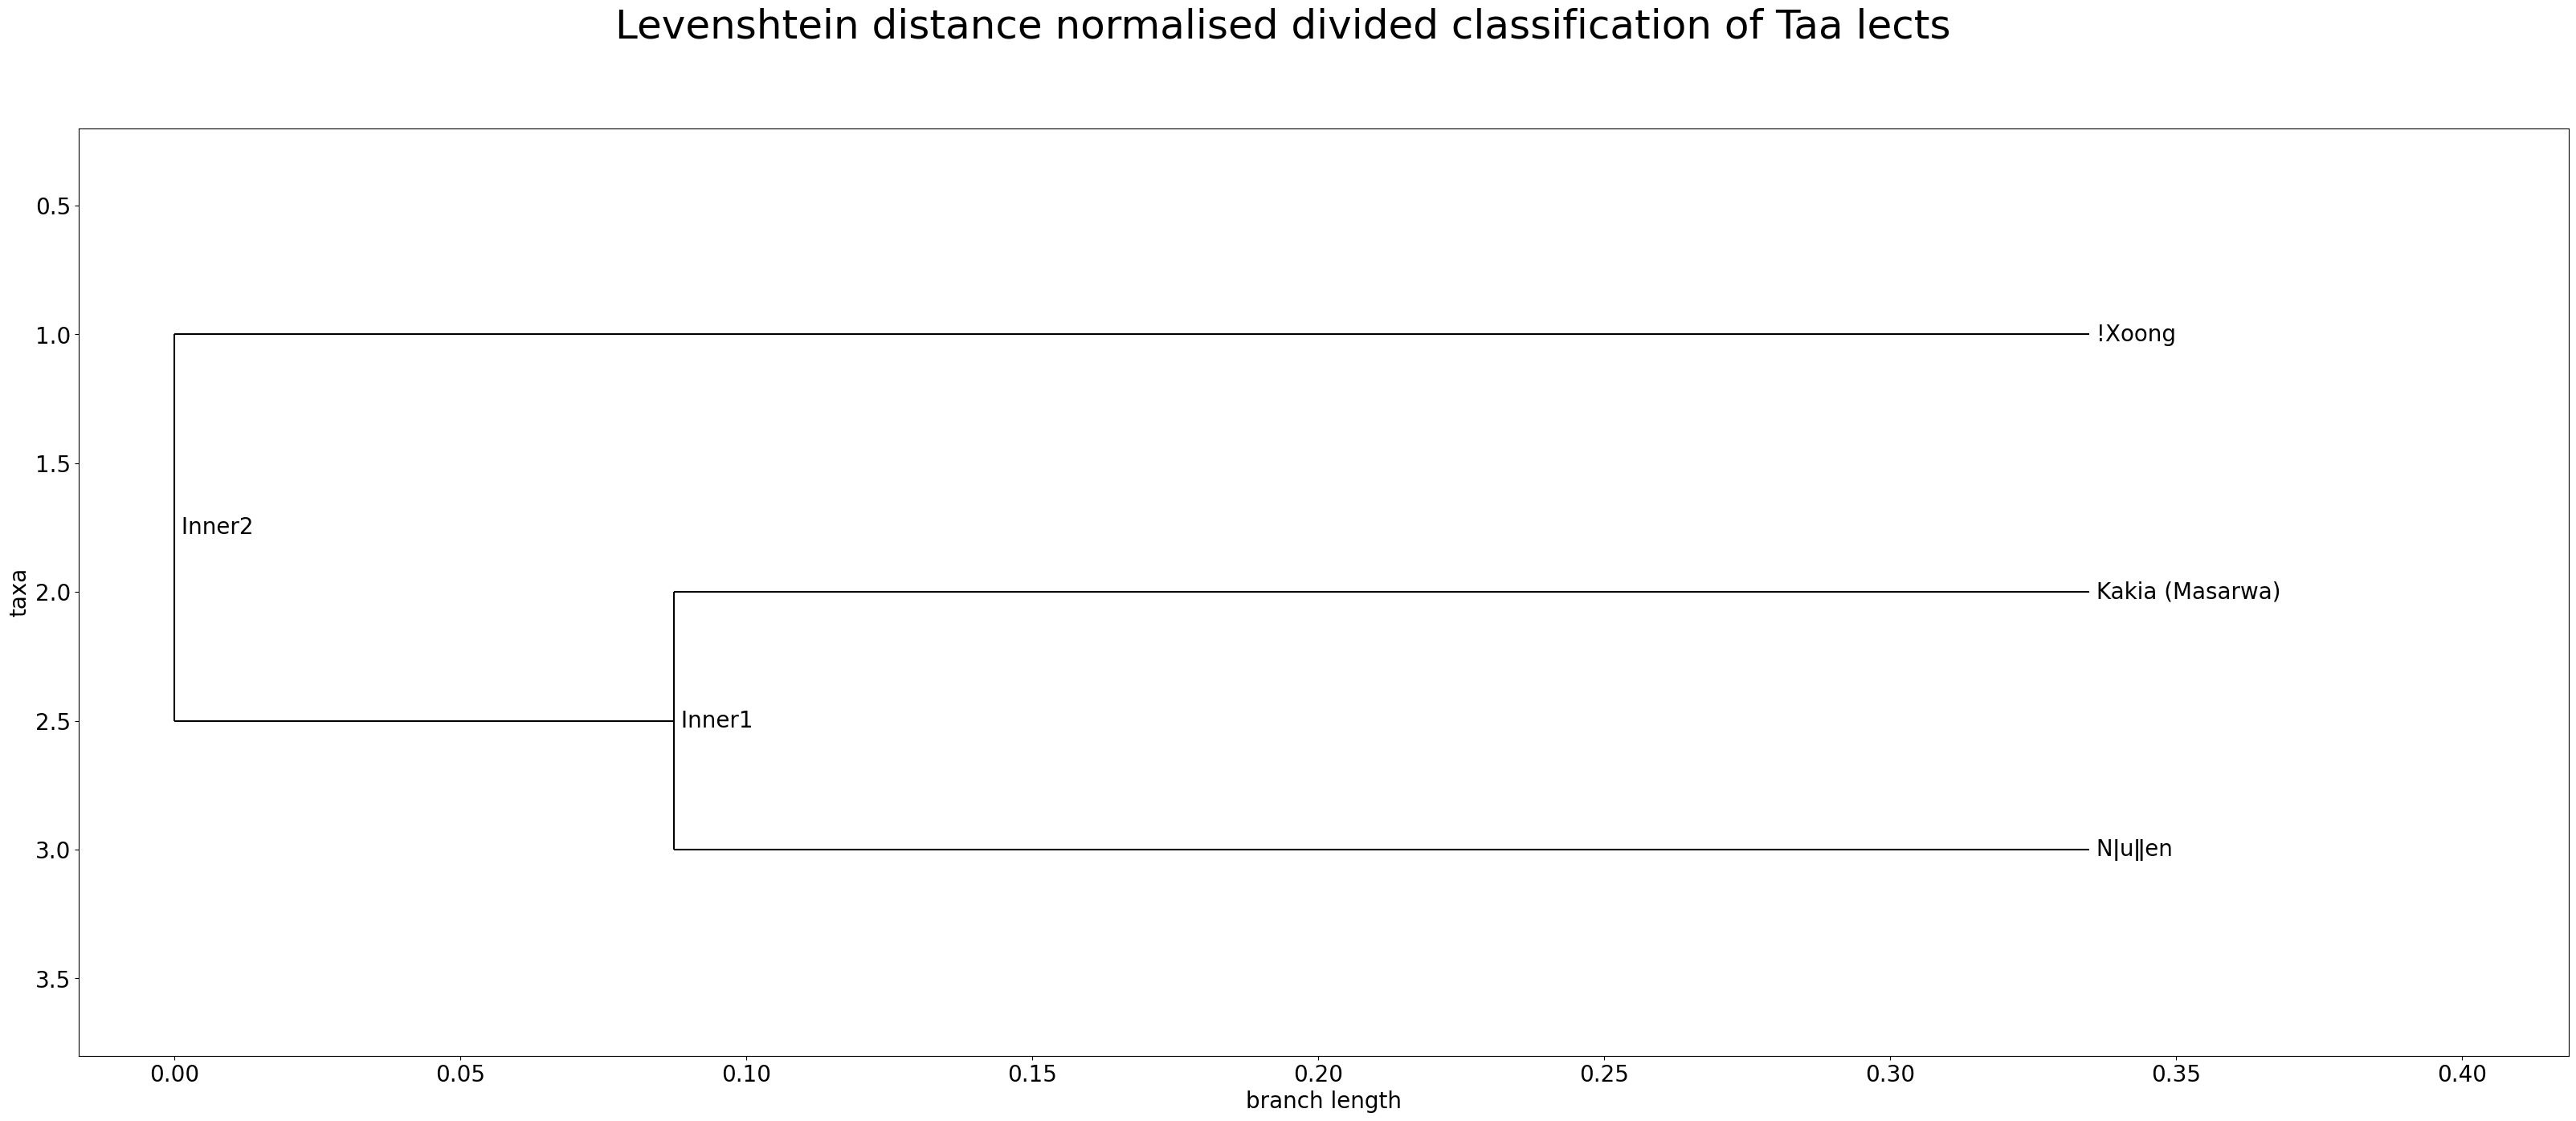

In [ ]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for this East Slavic lects does not differ in a drastic manner
tree = constructor.upgma(distance_matrix)
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':20}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 15))
fig.suptitle(f'Levenshtein distance normalised divided classification of {DATA}', fontsize=36)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_LDND_{DATA}.png')
plt.show()

In [ ]:
 # here, we also score difference in middle split between black-box and LDND
 # performs correctly, only if there were correct results for black-box
 assert middle_distances > 0
 inner1 = list(tree.find_clades('Inner1'))[0].branch_length
 print(f'Inner1 length is {inner1}')
 diff = abs(list(tree.find_clades('Inner1'))[0].branch_length - middle_distances)
 print(f'Deviation of black-box method from Levenshtein distance normalised divided is {diff}')

AssertionError: 

## Weighted Jaro-Winkler

Jaro-Winkler distance is a string similarity measure akin to Levenshtein distance. It is a metric that recently gained popularity in NLP, it fines more the strings that are less similar in their beginning symbols. We use the more efficient modification, weighted Jaro-Winkler metric (a multiplication of Jaro-Winkler distance and Levenshtein distance). We use it in normalised divided form, normalising both Jaro-Winkler distance and Levenshtein distance before multiplying them. Divided means the same as for Levenshtein distance: a mean of all the results.

In [ ]:
pairwise_distances = []
for i in tqdm(unique_pairs):
  neutral_lects = get_non_relevant_pairs(i, df_pairs)
  # get data for pair under consideration
  lect_1 = df[df['lect'] == i[0]]
  lect_2 = df[df['lect'] == i[1]]
  # get all the concept
  concepts = list(lect_1['concept'].unique())
  concept_distances = []
  # for each concept, we calculate normalised Levenshtein distance, then
  # Jaro-Winkler distance, then weight them
  for c in concepts:
    concept_in_lect_1 = lect_1[lect_1['concept'] == c].reset_index().loc[0, 'word']
    concept_in_lect_2 = lect_2[lect_2['concept'] == c].reset_index().loc[0, 'word']
    LDN = Levenshtein.distance(concept_in_lect_1, concept_in_lect_2)/max([len(concept_in_lect_1), len(concept_in_lect_2)])
    JWN = jw(concept_in_lect_1, concept_in_lect_2)/max([len(concept_in_lect_1), len(concept_in_lect_2)])
    concept_distances.append(LDN * (1 - JWN))
  # get mean for all the concepts in pair
  pairwise_distances.append((i, sum(concept_distances)/len(concept_distances)))
print(pairwise_distances)

100%|██████████| 3/3 [00:00<00:00, 16.75it/s]

[(('Nǀuǁen ', '!Xoong'), 0.6066565419501134), (('Nǀuǁen ', 'Kakia (Masarwa)'), 0.4405131227729188), (('!Xoong', 'Kakia (Masarwa)'), 0.5857870238095236)]


In [ ]:
# turning pairwise_distances in triangular matrix
final_matrix = []
# set size of matrix
for i in set(y):
  final_matrix.append([])
# prepare results for yielding the next one
pairwise_distances_cycled = cycle(pairwise_distances)
# set column and row variables for filling each slot, starting with (0, 0)
current_column = 0
current_max_row = current_column
# while we did not went through all the lects
while current_column < len(list(set(y))):
  # if we filled all the distances between this lect and others, add 0 distance between this lect and itself, and go to the next lect
  if (current_max_row == 0):
    final_matrix[current_column].append(0)
    current_column = current_column + 1
    current_max_row = current_column
    continue
  # otherwise, add distance between this lect and the next one
  final_matrix[current_column].append(next(pairwise_distances_cycled)[1])
  current_max_row = current_max_row - 1
print(final_matrix)

[[0], [0.6066565419501134, 0], [0.4405131227729188, 0.5857870238095236, 0]]


In [ ]:
# prepare triangular matrix: names of lects and distances between them
names = [str(i) for i in list(set(y))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)


Tree(rooted=False)
    Clade(branch_length=0, name='Inner1')
        Clade(branch_length=0.23069132045675433, name='Nǀuǁen ')
        Clade(branch_length=0.3759652214933591, name='!Xoong')
        Clade(branch_length=0.20982180231616449, name='Kakia (Masarwa)')


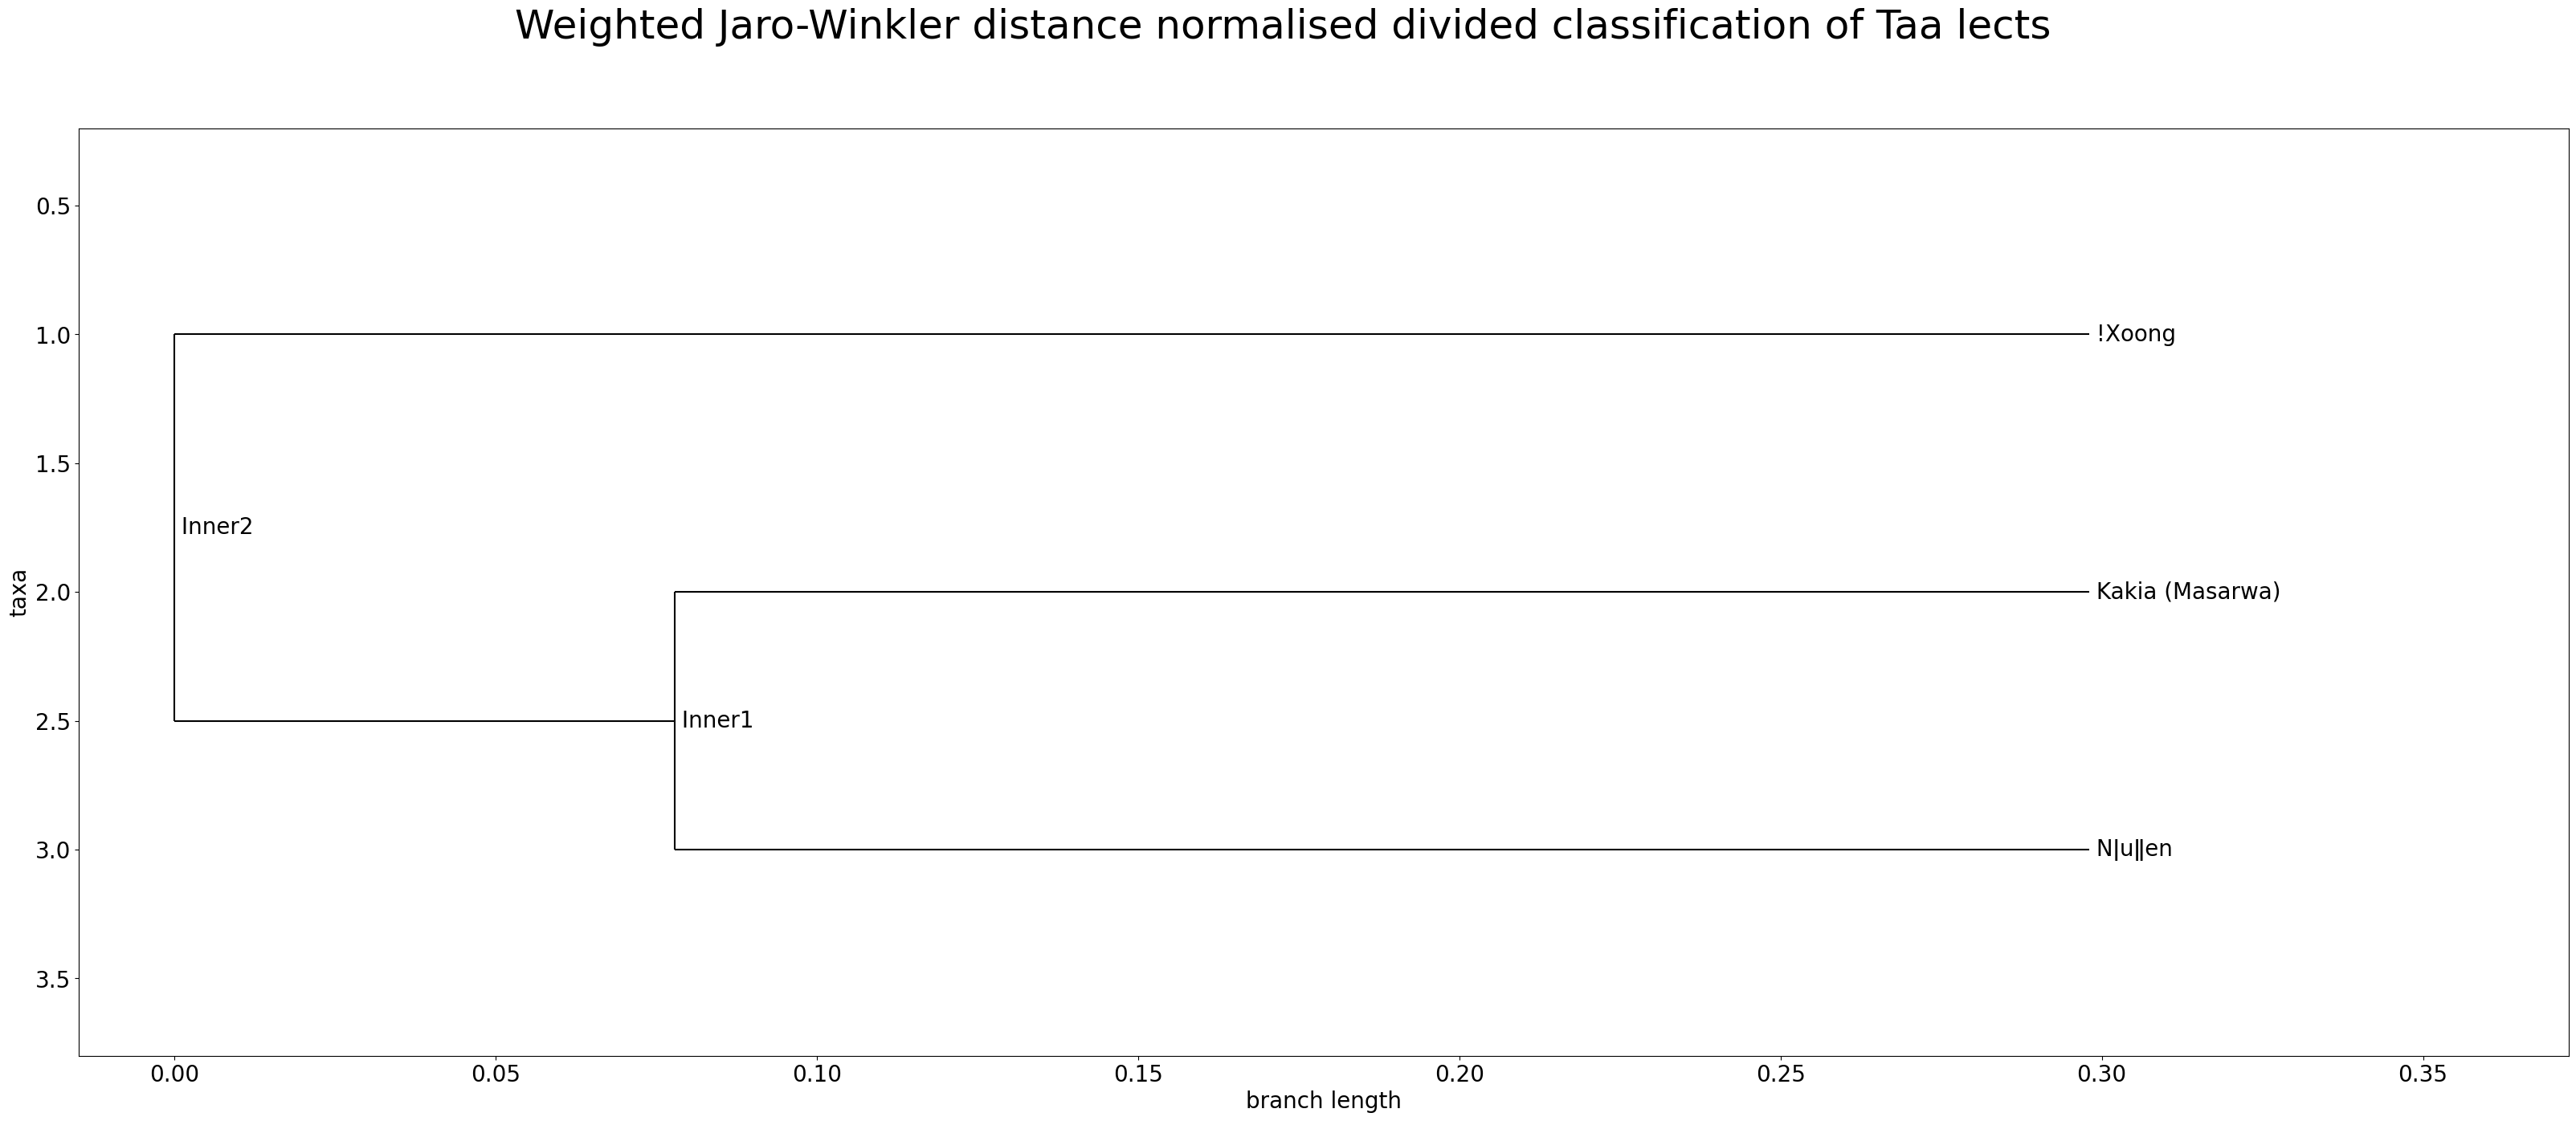

In [ ]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for this East Slavic lects does not differ in a drastic manner
tree = constructor.upgma(distance_matrix)
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':20}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 15))
fig.suptitle(f'Weighted Jaro-Winkler distance normalised divided classification of {DATA}', fontsize=36)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_WJWND_{DATA}.png')
plt.show()

In [ ]:
 # here, we also score difference in middle split between black-box and WJWND
 # performs correctly, only if there were correct results for black-box
 assert middle_distances > 0
 inner1 = list(tree.find_clades('Inner1'))[0].branch_length
 print(f'Inner1 length is {inner1}')
 diff = abs(list(tree.find_clades('Inner1'))[0].branch_length - middle_distances)
 print(f'Deviation of black-box method from Weighted Jaro-Winkler normalised divided is {diff}')

AssertionError: 

## Phonetics-aware string similarity measure

The last string similarity measure we use is [phonetics-aware string similarity measure](https://github.com/Stoneberry/phonetic-algorithmIPA). This is an algorithm, similar in behaviour to LDND. However, this algorithm also takes into account the phonetic properties of the added/deleted/substituted/transposed (as it uses Damerau-Levenshtein distance modification) symbols, and requires [IPA transcription](https://www.ipachart.com/) as an input. It is the most linguistically explainable algorithm out of the whole batch. We use it, yet again, in a normalised divided form, for results to be compatible to the other string similarity measures.

In [ ]:
# initialise PhoneticAlgorithmIPA
ipa = ipa_distances.PhoneticAlgorithmIPA()

In [ ]:
pairwise_distances = []
for i in tqdm(unique_pairs):
  neutral_lects = get_non_relevant_pairs(i, df_pairs)
  # get data for pair under consideration
  lect_1 = list(df[df['lect'] == i[0]]['word'])
  lect_2 = list(df[df['lect'] == i[1]]['word'])
  # write data into a temporary csv file
  with open('pair.csv', 'w', encoding='utf-8') as out:
    for j in zip(lect_1, lect_2):
      out.write(f'{j[0]};{j[1]}\n')
  # score distances, normalise them by the length of the bigger word from pair
  distances = ipa.phonetic_distance('pair.csv', normalize='max')
  # append mean
  pairwise_distances.append((i, sum(distances)/len(distances)))
  # remove a temporary file
  if os.path.exists("pair.csv"):
    os.remove("pair.csv")
print(pairwise_distances)

100%|██████████| 3/3 [00:00<00:00, 75.16it/s]

[(('Khislavichi (Eastern, Belarusian, Russia)', 'Meɡra (North, Russian, Russia)'), 0.08116391022004824), (('Khislavichi (Eastern, Belarusian, Russia)', 'Beloɡornoje (South, Russian, Russia)'), 0.043913603425149404), (('Meɡra (North, Russian, Russia)', 'Beloɡornoje (South, Russian, Russia)'), 0.037463291397023694)]


In [ ]:
# turning pairwise_distances in triangular matrix
final_matrix = []
# set size of matrix
for i in set(y):
  final_matrix.append([])
# prepare results for yielding the next one
pairwise_distances_cycled = cycle(pairwise_distances)
# set column and row variables for filling each slot, starting with (0, 0)
current_column = 0
current_max_row = current_column
# while we did not went through all the lects
while current_column < len(list(set(y))):
  # if we filled all the distances between this lect and others, add 0 distance between this lect and itself, and go to the next lect
  if (current_max_row == 0):
    final_matrix[current_column].append(0)
    current_column = current_column + 1
    current_max_row = current_column
    continue
  # otherwise, add distance between this lect and the next one
  final_matrix[current_column].append(next(pairwise_distances_cycled)[1])
  current_max_row = current_max_row - 1
print(final_matrix)

[[0], [0.08116391022004824, 0], [0.043913603425149404, 0.037463291397023694, 0]]


In [ ]:
# prepare triangular matrix: names of lects and distances between them
names = [str(i) for i in list(set(y))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)


Tree(rooted=False)
    Clade(branch_length=0, name='Inner1')
        Clade(branch_length=0.04380711112408697, name='Khislavichi (Eastern, Belarusian, Russia)')
        Clade(branch_length=0.03735679909596126, name='Meɡra (North, Russian, Russia)')
        Clade(branch_length=0.00010649230106243163, name='Beloɡornoje (South, Russian, Russia)')


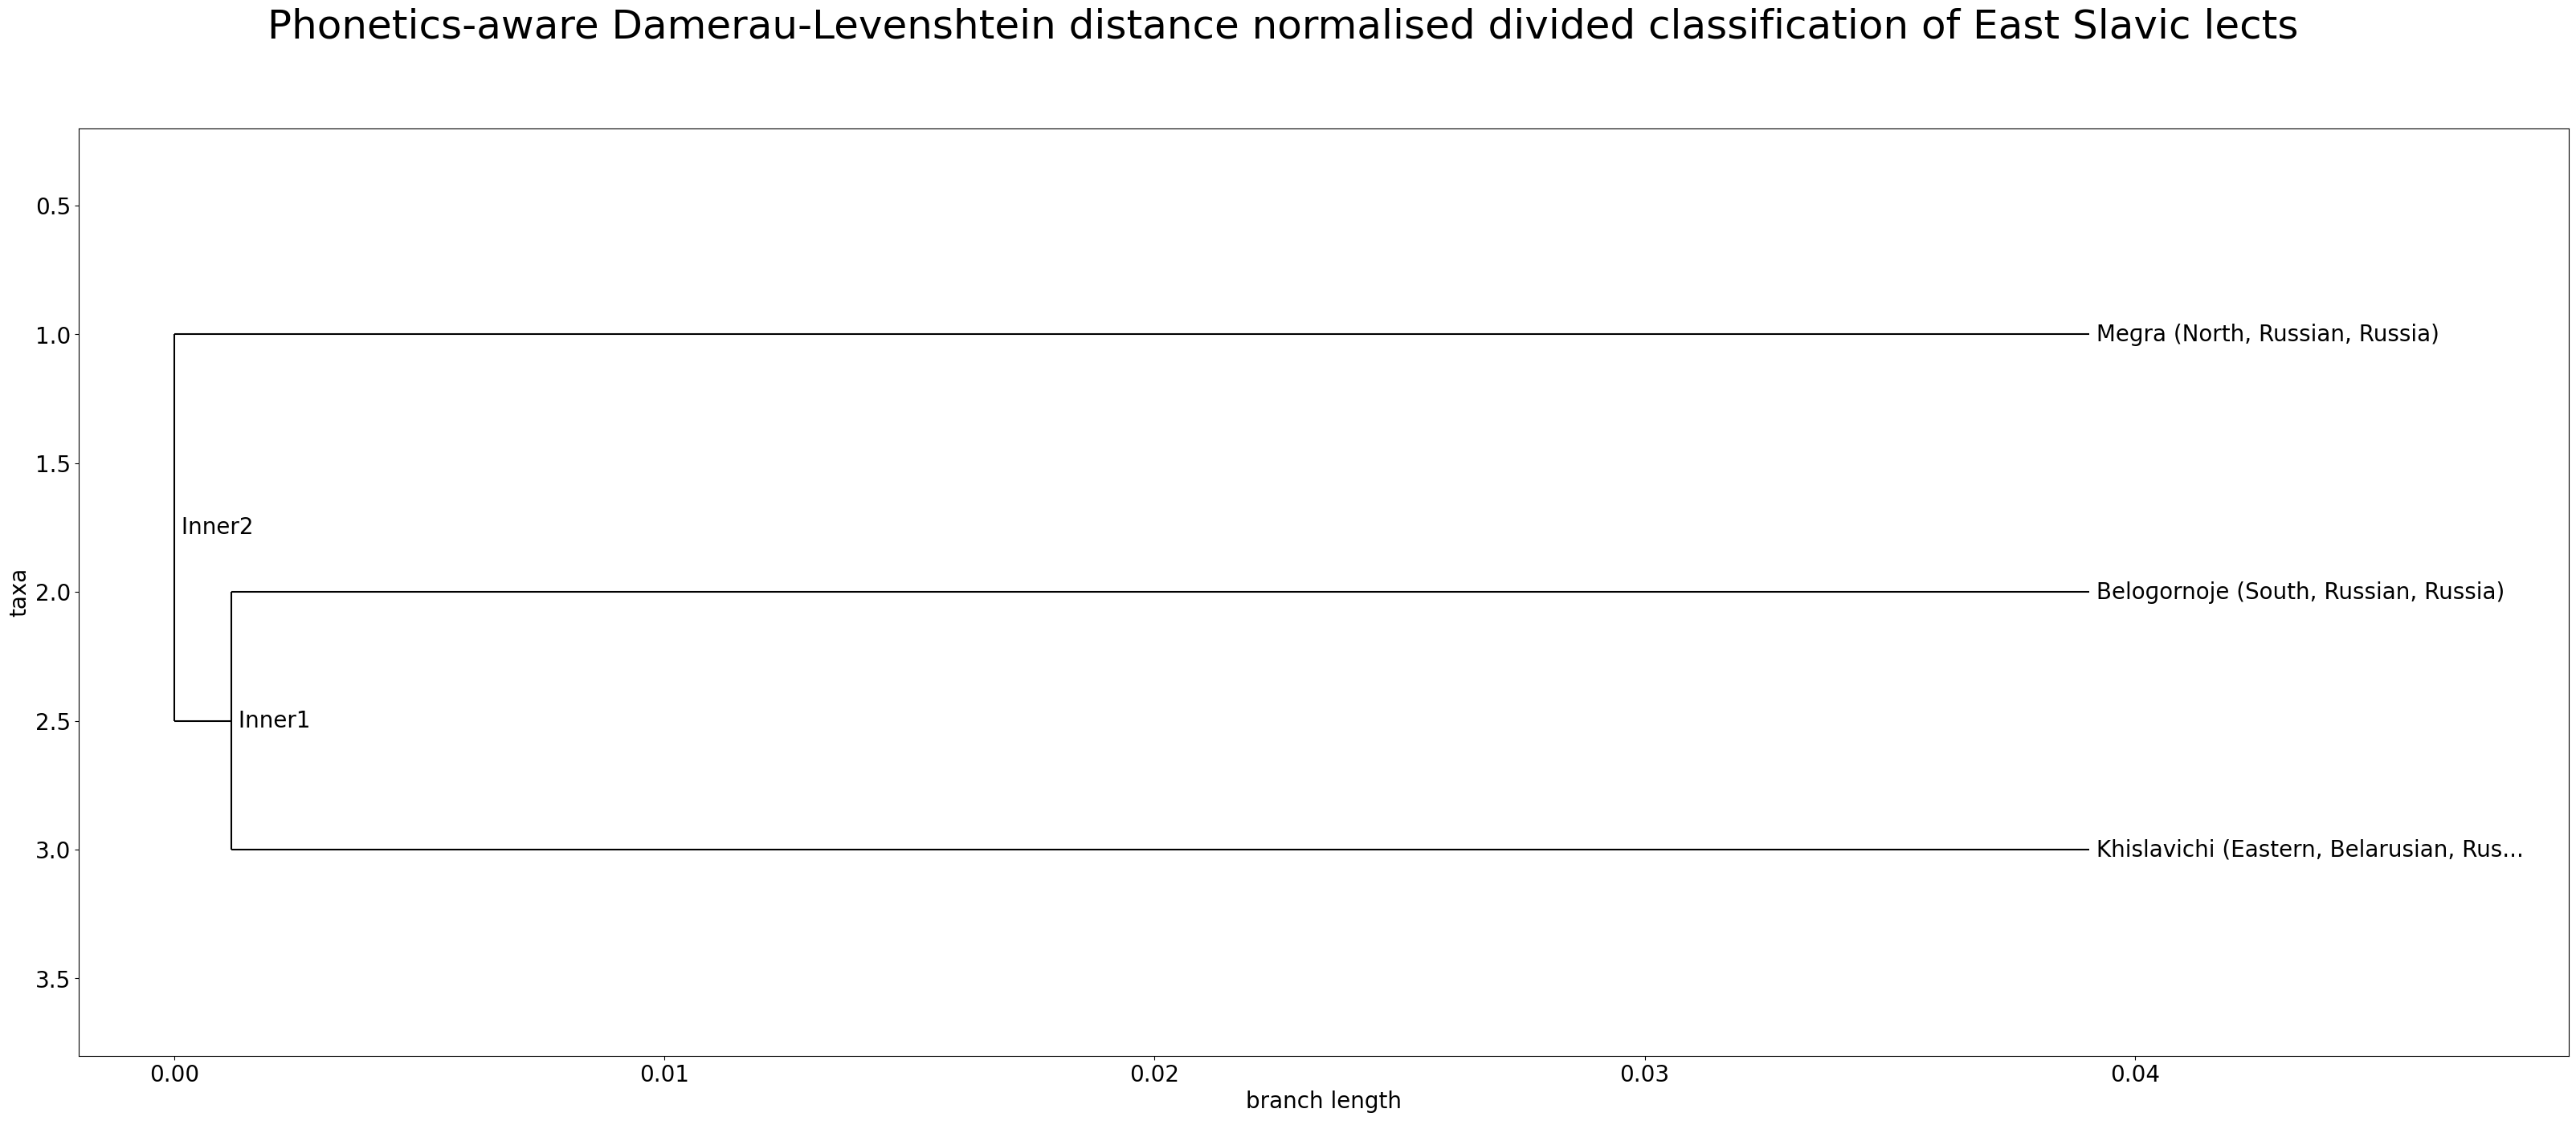

In [ ]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for this East Slavic lects does not differ in a drastic manner
tree = constructor.upgma(distance_matrix)
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':20}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 15))
fig.suptitle(f'Phonetics-aware Damerau-Levenshtein distance normalised divided classification of {DATA}', fontsize=36)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_phonetics_aware_{DATA}.png')
plt.show()

In [ ]:
 # here, we also score difference in middle split between black-box and PADLDND
 # performs correctly, only if there were correct results for black-box
 assert middle_distances > 0
 inner1 = list(tree.find_clades('Inner1'))[0].branch_length
 print(f'Inner1 length is {inner1}')
 diff = abs(list(tree.find_clades('Inner1'))[0].branch_length - middle_distances)
 print(f'Deviation of black-box method from Phonetics-aware Damerau-Levenshtein distance normalised divided is {diff}')

Inner1 length is 0.012537732712787564
Deviation of black-box method from Phonetics-aware Damerau-Levenshtein distance normalised divided is 0.011418371732570886


# Method cross-evaluation: phonetic features

We also implement a full alternative for a Swadesh list-based classification, a classification based on calculating Hamming distance between strings of phonetic features.

We start with loading dataset of the following format:
        
| Feature     | Lect1 | ... | LectN |
| ----------- | ----------- |----------- | ----------- |
| Feature 1 | Feature 1 in Lect 1 | ... | Feature 1 in lect N |
| ... | ... | ... | ... |
| Feature M | Feature M  in Lect 1 | ... | Feature M in lect N |

We treat features as sets {Realisation1, Realisation2, ..., RealisationN}<sub>feature</sub>. Each realisation gets a specific letter (we use A for the realisation we found first in the first analysed lect, B for the realisation we found first in the second analysed lect, and so forth). If there is no realisation of feature in a lect, we initially put **!** sign.

We use data from [Russian Language dialectology atlas](da.ruslang.ru), kindly provided to us by its authors.

In [ ]:
# We store current grammar dataset name in variable GRAMMAR_DATA,
# as it differs from lexicostatistical DATA
GRAMMAR_DATA = 'Russian dialects'
df = pd.read_csv('/content/Swadesh lists - Phonetic features for method cross-verification.csv', sep=',')
# we delete Feature field, as it is required on the preparation stage
df = df.drop(['Feature'], axis=1)

In [ ]:
lects = list(df.columns)

In [ ]:
lects

['Mokshenskaja (North, Russian, Russia)',
 'Piestchanka (South, Russian. Russia)',
 'Kritskovschina(Western, Russian, Russia)']

In [ ]:
# we transform dataset to dictionary with dialect names as keys,
# and strings of features as values. We change ! for -, as it is a general rule
# in phylogenetics.
features_to_strings = {}
for i in lects:
  features_to_strings[i] = re.sub('!', '-', ''.join(list(df[i])))

In [ ]:
features_to_strings

{'Mokshenskaja (North, Russian, Russia)': 'A-AAAAA-AA-A---AA-AA-AAA-AA-A-AAAAA---AAAAA-A-A-AA--AAA-AAAAAAAA-AAAAAAAAAAAAA--AAA-A---AAAAA-A-----AAAAA---A--A-A-AA-A--------A-A-----',
 'Piestchanka (South, Russian. Russia)': 'A-AAAABBB--A---A--BA-AAA-AABABAAAABBBB-AAAA-ABA-AB--A-A-AAAABA-BB-AA-A--BBBA-A--A-A-A--BA-AAA---B----AA-A-BBBBBABA-ABBA--B-----B-ABBBBB',
 'Kritskovschina(Western, Russian, Russia)': 'CCCC-------CCCCC--CCCCCCC-AС-С--СС-СС-СC-C-C-CCCC------A---C-BA--B--A-AA----AACCC-ACCCCC-A-AA---------AC-C-CBBBB--A-AAB---BC----CCC-----'}

In [ ]:
# we form pairs to compare
unique_pairs = []
for i in set(lects):
  for j in set(lects):
    if (i != j) and (i, j) not in unique_pairs and (j, i) not in unique_pairs:
      unique_pairs.append((i, j))
print(unique_pairs)

[('Piestchanka (South, Russian. Russia)', 'Kritskovschina(Western, Russian, Russia)'), ('Piestchanka (South, Russian. Russia)', 'Mokshenskaja (North, Russian, Russia)'), ('Kritskovschina(Western, Russian, Russia)', 'Mokshenskaja (North, Russian, Russia)')]


In [ ]:
pairwise_distances = []
for i in tqdm(unique_pairs):
  # we get the strings of features for a current pair of lects
  lect_1 = features_to_strings[i[0]]
  lect_2 = features_to_strings[i[1]]
  # we use Hamming distance, the most suitable for working with strings of
  # same size.
  distance = Levenshtein.hamming(lect_1, lect_2)
  max_len = max([len(lect_1), len(lect_2)])
  # we append normalised distance for a more transparent comparison
  pairwise_distances.append((i, distance/max_len))
print(pairwise_distances)

100%|██████████| 3/3 [00:00<00:00, 4154.15it/s]

[(('Piestchanka (South, Russian. Russia)', 'Kritskovschina(Western, Russian, Russia)'), 0.7867647058823529), (('Piestchanka (South, Russian. Russia)', 'Mokshenskaja (North, Russian, Russia)'), 0.37037037037037035), (('Kritskovschina(Western, Russian, Russia)', 'Mokshenskaja (North, Russian, Russia)'), 0.7205882352941176)]


In [ ]:
# turning pairwise_distances in triangular matrix
final_matrix = []
# set size of matrix
for i in set(lects):
  final_matrix.append([])
# prepare results for yielding the next one
pairwise_distances_cycled = cycle(pairwise_distances)
# set column and row variables for filling each slot, starting with (0, 0)
current_column = 0
current_max_row = current_column
# while we did not went through all the lects
while current_column < len(list(set(lects))):
  # if we filled all the distances between this lect and others, add 0 distance between this lect and itself, and go to the next lect
  if (current_max_row == 0):
    final_matrix[current_column].append(0)
    current_column = current_column + 1
    current_max_row = current_column
    continue
  # otherwise, add distance between this lect and the next one
  final_matrix[current_column].append(next(pairwise_distances_cycled)[1])
  current_max_row = current_max_row - 1
print(final_matrix)

[[0], [0.7867647058823529, 0], [0.37037037037037035, 0.7205882352941176, 0]]


In [ ]:
# prepare triangular matrix: names of lects and distances between them
names = [str(i) for i in list(set(lects))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)


Tree(rooted=False)
    Clade(branch_length=0, name='Inner1')
        Clade(branch_length=0.21827342047930287, name='Piestchanka (South, Russian. Russia)')
        Clade(branch_length=0.56849128540305, name='Kritskovschina(Western, Russian, Russia)')
        Clade(branch_length=0.15209694989106753, name='Mokshenskaja (North, Russian, Russia)')


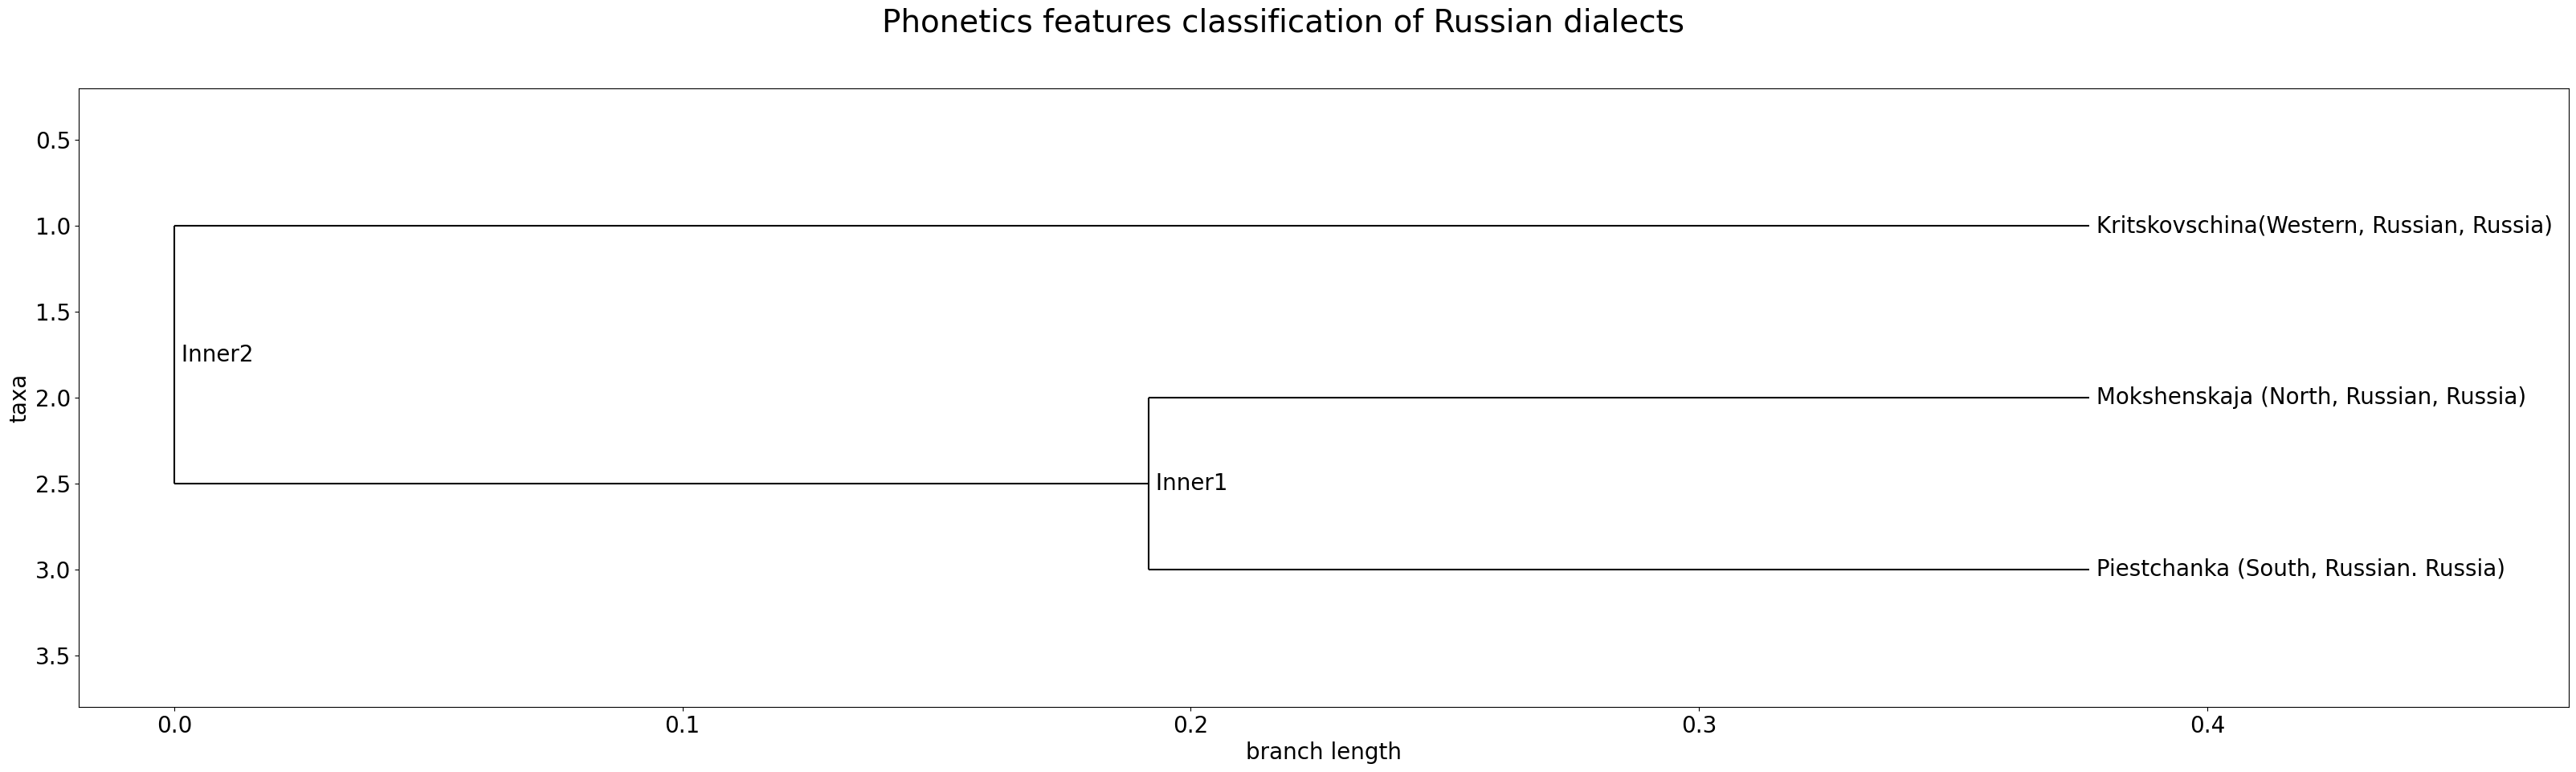

In [ ]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for this East Slavic lects does not differ in a drastic manner
tree = constructor.upgma(distance_matrix)
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':20}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 10))
fig.suptitle(f'Phonetics features classification of {GRAMMAR_DATA}', fontsize=28)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_phonetics_features_{GRAMMAR_DATA}.png')
plt.show()

In [ ]:
 # here, we also score difference in middle split between black-box and PAHD
 # performs correctly, only if there were correct results for black-box
 # we divide PAHD by 10, as it significantly magnifies the differences
 # between lects
 assert middle_distances > 0
 inner1 = list(tree.find_clades('Inner1'))[0].branch_length
 print(f'Inner1 length is {inner1}')
 diff = abs(list(tree.find_clades('Inner1'))[0].branch_length - middle_distances)
 print(f'Deviation of black-box method from Phonetics features Hamming distance is {diff}')

Inner1 length is 0.19165305010893247
Deviation of black-box method from Phonetics features Hamming distance is 0.1905336891287158
